<div style="text-align: center; font-size: 30px">
    Final project: Welcome to Rick and Morty's world!
</div>


<div style="text-align: center; font-size: 20px">
    By Nicola Bagnoli s232692 and Helle Achari s180317
</div>


INTRODUCTION AT LAST

The notebook includes comments where it is seen necessary to understand the step

The notebook is divided into parts for a more structured feel. 

# Part 1: Gettting the necessary data

Before getting starting we need to import all the necessary packages.

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import json
import os
import re
import seaborn as sns
from tabulate import tabulate
from urllib.parse import urljoin  
import pickle as pkl
import community as community_louvain
from collections import Counter
from fa2_modified import ForceAtlas2
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from PIL import Image
from rapidfuzz import process
import matplotlib.patches as mpatches
import string
from nltk.corpus import stopwords
import contractions
import nltk


## Part 1.1: Extracting Characters information

The initial attempt was to extract data about the characters and the episodes by extracting it from the Fandom Wiki page. Randomly, we came across an API created by a fellow Rick and Morty fan (https://rickandmortyapi.com/) that provided all necessary information. This eliminated to manually cleaning and parsing the data from the Fandom Wiki page, which also consisted of inconsistent HTML caused by different authors. The API includes data up to 2021,  covering up until season 5, but season 6 and 7 are missing.  To maintain consistency with the original format, season 6 will manually be added to the dataset with data, characters and locations. Meanwhile, Season 7 will be excluded from the dataset due to its poorly transcribed content.

In [ ]:
def scrape_episode_page(episode_url):
    response = requests.get(episode_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    title = soup.find("h1", class_="page-header__title").get_text(strip=True)

    # Extract air date near "PREMIERE DATE"
    air_date = None
    premiere_date_header = soup.find("h3", class_="pi-data-label pi-secondary-font", string="PREMIERE DATE")
    if premiere_date_header:
        air_date_div = premiere_date_header.find_next("div", class_="pi-data-value pi-font")
        if air_date_div:
            for sup_tag in air_date_div.find_all("sup"):
                sup_tag.decompose()
            air_date = air_date_div.get_text(strip=True)

    characters = {"major": [], "minor": []}

    def get_full_name(a_tag):
        return a_tag.get_text(strip=True) or a_tag.get("title", "").strip()

    # Find the Characters section (major and minor)
    for header in soup.find_all("h3"):
        header_text = header.get_text(strip=True).lower()
        if "major characters" in header_text:
            ul = header.find_next("ul")
            if ul:
                characters["major"] = [get_full_name(a) for a in ul.find_all("a", title=True)]
        elif "minor characters" in header_text:
            ul = header.find_next("ul")
            if ul:
                characters["minor"] = [get_full_name(a) for a in ul.find_all("a", title=True)]

    # Combine characters for simplicity
    all_characters = characters["major"] + characters["minor"]

    return {"title": title, "air_date": air_date, "characters": all_characters}

# Example: Scrape one episode
episode_url = "https://rickandmorty.fandom.com/wiki/Solaricks"
episode_data = scrape_episode_page(episode_url)

print(f"Title: {episode_data['title']}")
print(f"Air Date: {episode_data['air_date']}")
print(f"Characters: {', '.join(episode_data['characters'])}")

Title: Solaricks
Air Date: September 4, 2022
Characters: Rick Sanchez, Morty Smith, Summer Smith, Beth Smith, Jerry Smith, Space Beth, Rick Prime, Evil Morty, Diane Sanchez, Beth Sanchez (C-137), Jerry Smith Prime, Mr. Frundles, Jerry Smith (C-131), Beth Smith Prime, Summer Smith Prime, Rick Sanchez (C-131), Morty Smith (C-131), Mr. Goldmanbachmajorian, Left-Handed Morty, Rick Sanchez (Parmesan Dimension), Morty Smith (Parmesan Dimension), Summer Smith (Parmesan Dimension), Beth Smith (Parmesan Dimension), Jerry Smith (Parmesan Dimension), Space Beth (Parmesan Dimension)


In [ ]:
# List of Season 6 episode URLs
episode_links = [
    "https://rickandmorty.fandom.com/wiki/Solaricks",
    "https://rickandmorty.fandom.com/wiki/Rick:_A_Mort_Well_Lived",
    "https://rickandmorty.fandom.com/wiki/Bethic_Twinstinct",
    "https://rickandmorty.fandom.com/wiki/Night_Family",
    "https://rickandmorty.fandom.com/wiki/Final_DeSmithation",
    "https://rickandmorty.fandom.com/wiki/JuRicksic_Mort",
    "https://rickandmorty.fandom.com/wiki/Full_Meta_Jackrick",
    "https://rickandmorty.fandom.com/wiki/Analyze_Piss",
    "https://rickandmorty.fandom.com/wiki/A_Rick_in_King_Mortur%27s_Mort",
    "https://rickandmorty.fandom.com/wiki/Ricktional_Mortpoon%27s_Rickmas_Mortcation"
]

# Scrape all episodes
episodes_data = []
for url in episode_links:
    episodes_data.append(scrape_episode_page(url))

for episode in episodes_data:
    print(f"Title: {episode['title']}")
    print(f"Air Date: {episode['air_date']}")
    print(f"Characters: {', '.join(episode['characters'])}\n")

Title: Solaricks
Air Date: September 4, 2022
Characters: Rick Sanchez, Morty Smith, Summer Smith, Beth Smith, Jerry Smith, Space Beth, Rick Prime, Evil Morty, Diane Sanchez, Beth Sanchez (C-137), Jerry Smith Prime, Mr. Frundles, Jerry Smith (C-131), Beth Smith Prime, Summer Smith Prime, Rick Sanchez (C-131), Morty Smith (C-131), Mr. Goldmanbachmajorian, Left-Handed Morty, Rick Sanchez (Parmesan Dimension), Morty Smith (Parmesan Dimension), Summer Smith (Parmesan Dimension), Beth Smith (Parmesan Dimension), Jerry Smith (Parmesan Dimension), Space Beth (Parmesan Dimension)

Title: Rick: A Mort Well Lived
Air Date: September 11, 2022
Characters: Rick Sanchez, Morty Smith, Summer Smith, Marta, Roy Parsans, Larry, President Leland, Kevin, Tony

Title: Bethic Twinstinct
Air Date: September 18, 2022
Characters: Space Beth, Beth Smith, Jerry Smith, Rick Sanchez, Morty Smith, Summer Smith, Beth Smith (5126), Jerry's school friend, Naruto Smith

Title: Night Family
Air Date: September 25, 2022
C

Now that we sucessfully have a list of episodes and the characters appearing in each one, it's time to cross-check this information with the characters obtained through scraping and their corresponding JSON files.

In [ ]:
# Normalize and clean character names to ensure consistent matching
def normalize_name(name):
    name = re.sub(r"[^a-zA-Z0-9_]", "", name.lower().replace(" ", "_"))
    return name

# List all unique characters in Season 6
def list_all_season_characters(episodes_data):
    all_characters = []
    for episode in episodes_data:
        all_characters.extend(episode["characters"])
    return sorted(set(all_characters))

# Compare characters to JSON file names
def check_character_json_files(character_list, json_folder_path):
    normalized_character_list = [normalize_name(char) for char in character_list]
    json_files = {normalize_name(file.replace(".json", "")) for file in os.listdir(json_folder_path) if file.lower().endswith(".json")}
    missing_json_files = [char for char in character_list if normalize_name(char) not in json_files]
    return missing_json_files

season_6_characters = list_all_season_characters(episodes_data)

json_folder_path = "rickmorty_characters"

missing_files = check_character_json_files(season_6_characters, json_folder_path)

if missing_files:
    print(f"\nCharacters without JSON files ({len(missing_files)}):")
    print("\n".join(missing_files))
else:
    print("\nAll characters have matching JSON files!")


Characters without JSON files (4):
Baby Poopybutthole
Roy
Roy Parsans
The President


Some characters are missing because they were not listed directly on the "Characters" pages of the wiki. To address this, we will search for their individual pages by appending their names to the URLs. These links must exist since having a valid page link was a prerequisite for extracting characters from the original pages.

In [ ]:

def extract_infobox_data(soup):
    desired_infobox_fields = {
        "SPECIES": "Species",
        "TYPE": "Type",
        "AGE": "Age",
        "AVERAGE LIFESPAN": "Average Lifespan",
        "STATUS": "Status",
        "OCCUPATION": "Occupation",
        "HOME PLANET": "Home Planet",
        "PLACE OF ORIGIN": "Place of Origin",
        "AFFILIATION": "Affiliation",
        "FAMILY": "Family",
        "FIRST APPEARANCE": "First Appearance",
        "FIRST SEEN IN": "First Appearance",
        "VOICE ACTOR": "Voice Actor",
    }

    infobox = soup.find("aside", {"role": "region"})
    infobox_data = {field_name: None for field_name in set(desired_infobox_fields.values())}

    if infobox:
        for item in infobox.find_all("div", class_="pi-item pi-data pi-item-spacing pi-border-color"):
            label = item.find("h3", class_="pi-data-label pi-secondary-font")
            value = item.find("div", class_="pi-data-value pi-font") 
            
            if label and value:
                label_text = label.get_text(strip=True).upper()
                
                # Handle fields with multiple entries like "FAMILY"
                if label_text in desired_infobox_fields and label_text == "FAMILY":
                    family_entries = []
                    for sub_entry in value.find_all("a"):
                        family_text = sub_entry.get_text(strip=True)
                        sibling_text = sub_entry.next_sibling.strip() if sub_entry.next_sibling else ""
                        full_entry = f"{family_text} {sibling_text}".strip()
                        family_entries.append(full_entry)
                    infobox_data[desired_infobox_fields[label_text]] = ", ".join(family_entries)
                
                elif label_text in desired_infobox_fields:
                    infobox_data[desired_infobox_fields[label_text]] = value.get_text(strip=True)

    return infobox_data

In [ ]:
# Use the adjusted extract_infobox_data function
def scrape_character_infobox(character_url):
    try:
        response = requests.get(character_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        name = soup.find("h1", class_="page-header__title").get_text(strip=True)
        infobox_data = extract_infobox_data(soup)
        character_data = {
            "name": name,
            "infobox": infobox_data,
        }
        
        filename = f"{'rickmorty_characters'}/{name.replace(' ', '_')}.json"
        with open(filename, "w", encoding="utf-8") as f:
            json.dump(character_data, f, indent=4)
        
        print(f"Saved {name} data to {filename}")
        return character_data

    except Exception as e:
        print(f"Failed to scrape {character_url}: {e}")
        return None

In [34]:
def scrape_multiple_characters(character_names, base_url):
    for character in character_names:
        character_url = f"{base_url}/{character.replace(' ', '_')}"
        try:
            print(f"Scraping: {character}")
            scrape_character_infobox(character_url)
        except Exception as e:
            print(f"Failed to scrape {character}: {e}")

base_url = "https://rickandmorty.fandom.com/wiki"

# Scrape all missing characters
scrape_multiple_characters(missing_files, base_url)

Scraping: Baby Poopybutthole
Saved Poopy Jr. data to rickmorty_characters/Poopy_Jr..json
Scraping: Roy
Saved Roy Parsons data to rickmorty_characters/Roy_Parsons.json
Scraping: Roy Parsans
Failed to scrape https://rickandmorty.fandom.com/wiki/Roy_Parsans: 404 Client Error: Not Found for url: https://rickandmorty.fandom.com/wiki/Roy_Parsans
Scraping: The President
Saved President Curtis data to rickmorty_characters/President_Curtis.json


After successfully obtaining JSON files for three of the characters, we can now proceed to handle the data retrieved from the API.

## Part 1.2 Data from the API to a df for easier data manipulation and analysis

In [ ]:
characters = []

# API endpoint for characters
url = 'https://rickandmortyapi.com/api/character'

# Loop through all pages
while url:
    response = requests.get(url)
    data = response.json()
    characters.extend(data['results'])
    url = data['info']['next']

# Convert to DataFrame
df_characters = pd.DataFrame(characters)

In [36]:
print(df_characters.columns)

Index(['id', 'name', 'status', 'species', 'type', 'gender', 'origin',
       'location', 'image', 'episode', 'url', 'created'],
      dtype='object')


It is now time to incorporate the scraped data from Season 6 into the dataframe, ensuring it aligns with the existing format while making minimal adjustments.


We begin by mapping the episode names to a placeholder API URL to maintain the structure of the dataframe. For our analysis, it doesn't matter if the link doesn't lead to an actual website.


In [ ]:
# Map Season 6 episode titles to API URLs
season_6_episode_mapping = {}

# Start from 52. episode for Season 6
api_episode_start_id = 52 

for idx, episode_url in enumerate(episode_links, start=api_episode_start_id):
    response = requests.get(episode_url)
    soup = BeautifulSoup(response.text, "html.parser")
    title = soup.find("h1", class_="page-header__title").get_text(strip=True)
    season_6_episode_mapping[title] = f"https://rickandmortyapi.com/api/episode/{idx}"

print("Season 6 Episode Mapping:")
print(season_6_episode_mapping)

Season 6 Episode Mapping:
{'Solaricks': 'https://rickandmortyapi.com/api/episode/52', 'Rick: A Mort Well Lived': 'https://rickandmortyapi.com/api/episode/53', 'Bethic Twinstinct': 'https://rickandmortyapi.com/api/episode/54', 'Night Family': 'https://rickandmortyapi.com/api/episode/55', 'Final DeSmithation': 'https://rickandmortyapi.com/api/episode/56', 'JuRicksic Mort': 'https://rickandmortyapi.com/api/episode/57', 'Full Meta Jackrick': 'https://rickandmortyapi.com/api/episode/58', 'Analyze Piss': 'https://rickandmortyapi.com/api/episode/59', "A Rick in King Mortur's Mort": 'https://rickandmortyapi.com/api/episode/60', "Ricktional Mortpoon's Rickmas Mortcation": 'https://rickandmortyapi.com/api/episode/61'}


In [ ]:
folder_path = "rickmorty_characters"  

def normalize_name(name):
    return name.strip().lower()

# Update or add characters based on Season 6 data
for episode in episodes_data:  # Season 6 scraped episode data
    episode_title = episode["title"]
    episode_url = season_6_episode_mapping.get(episode_title)

    if not episode_url:
        continue

    for character in episode["characters"]:
        normalized_character = normalize_name(character)

        if normalized_character in df_characters['name'].str.lower().values:
            match = df_characters['name'].str.lower() == normalized_character
            df_characters.loc[match, 'episode'] = df_characters.loc[match, 'episode'].apply(
                lambda x: x + [episode_url] if isinstance(x, list) else [episode_url]
            )
        else:
            # Character does not exist; retrieve info from JSON and add to the dataset df_characters
            json_file_path = os.path.join(folder_path, f"{character.replace(' ', '_')}.json")
            if os.path.exists(json_file_path):
                with open(json_file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    new_character = {
                        "id": None,
                        "name": data.get("name"),
                        "status": data["infobox"].get("STATUS", None),
                        "species": data["infobox"].get("SPECIES", None),
                        "type": data["infobox"].get("TYPE", None),
                        "origin": data["infobox"].get("PLACE OF ORIGIN", None),
                        "location": None,  
                        "episode": [episode_url]
                    }
                
                    df_characters = pd.concat([df_characters, pd.DataFrame([new_character])], ignore_index=True)

# Fill missing IDs for new characters
if df_characters['id'].isnull().any():
    max_id = df_characters['id'].max() or 0
    df_characters.loc[df_characters['id'].isnull(), 'id'] = range(int(max_id) + 1, int(max_id) + 1 + df_characters['id'].isnull().sum())

df_characters.to_csv("updated_characters.csv", index=False)

print("Updated DataFrame saved to updated_characters.csv")

Updated DataFrame saved to updated_characters.csv


With our dataset now updated, we will handle the NaN values by replacing them with either 'Normal' or 'Unknown', depending on the specific category.

In [39]:
# Fill rows with no type (NaN or empty string) with "Normal"
df_characters["type"] = df_characters["type"].apply(
    lambda x: "Normal" if pd.isnull(x) or str(x).strip() == "" else x
)

print(df_characters["type"].value_counts())

type
Normal                  458
Soulless Puppet          46
Decoy                    26
Parasite                 19
Snake                    14
                       ... 
Scarecrow                 1
Tiger                     1
Crow Horse                1
Ferret Robot              1
Passing Butter Robot      1
Name: count, Length: 170, dtype: int64


In [ ]:
# Replace missing values (NaN) in the 'species' column with "Unknown"
df_characters["species"] = df_characters["species"].fillna("unknown")

# Replace 'None' (as a string) in the 'species' column with "Unknown"
df_characters["species"] = df_characters["species"].replace("None", "unknown")

print(df_characters["species"].value_counts())

species
Human                                     366
Alien                                     205
unknown                                    69
Humanoid                                   68
Animal                                     55
Robot                                      51
Mythological Creature                      46
Poopybutthole                               8
Cronenberg                                  8
Disease                                     6
Cybernetically EnhancedHuman(or clone)      1
Name: count, dtype: int64


With the dataframe complete and the NaN values handled, the next step is to explore and construct the network.

# Part 2: Diving deeper into the network structure of the data

In [ ]:
G = nx.Graph()

for idx, row in df_characters.iterrows():
    G.add_node(row['id'], name=row['name'], species=row['species'],
               status=row['status'], gender=row['gender'], type=row['type'],
               origin=row['origin'], location=row['location'])

# Build edges between characters appearing in the same episodes
# First, create a mapping from character IDs to episodes
character_episodes = dict(zip(df_characters['id'], df_characters['episode']))

# Create edges
for char1 in G.nodes():
    for char2 in G.nodes():
        # Avoid duplicate edges
        if char1 < char2:  
            shared_episodes = set(character_episodes[char1]) & set(character_episodes[char2])
            if shared_episodes:
                # The weight is the number of shared episodes
                G.add_edge(char1, char2, weight=len(shared_episodes))

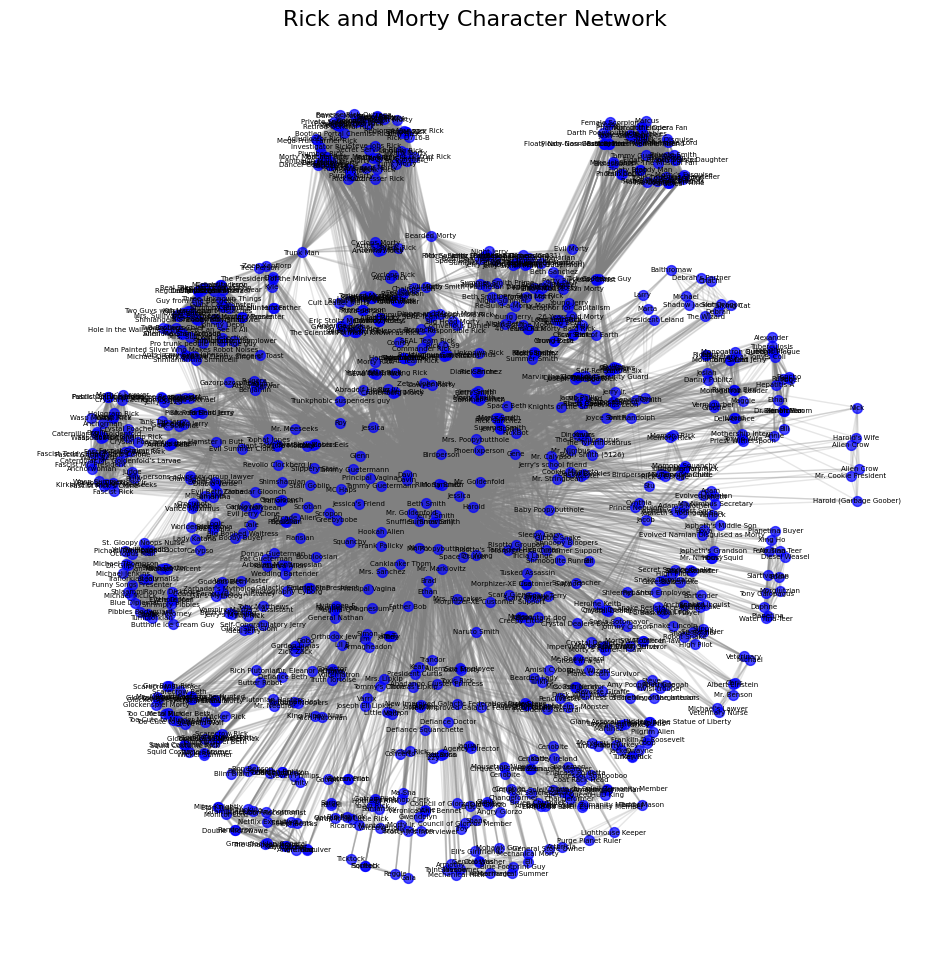

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)
weights = [d['weight'] for (_, _, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray', width=weights)
labels = {n: G.nodes[n]['name'] for n in G.nodes() if G.degree(n) > 3}
nx.draw_networkx_labels(G, pos, labels, font_size=5, font_color='black')

plt.title("Rick and Morty Character Network", fontsize=16)
plt.axis('off')
plt.show()

<div style="text-align: center; font-size: 14px">
    <em> <strong>Figure 1: Rick and Morty Network</strong> <br> Visualization of the character network, showcasing interactions and relationships among characters in the series. Each character is presented as a node with the color blue. Each relationship between two chracters appearing in the same episode is indicated by a grey edge. </em>
</div>


In [43]:
print("Number of nodes (characters):", G.number_of_nodes())
print("Number of edges (relationships):", G.number_of_edges())

Number of nodes (characters): 883
Number of edges (relationships): 19557


We have now constructed the initial network, where the nodes represent characters, and edges are created between two characters if they appear in the same episode. The network consists 883 characters and 19,557 edges.

Quick check to see how the different versions of the main characters are stored in the df.

In [44]:
# List of characters to filter
characters_to_display = ["Jerry Smith", "Summer Smith", "Beth Smith"]

# Filter rows for the specified characters
filtered_characters = df_characters[df_characters['name'].isin(characters_to_display)]

# Sort the filtered rows by name
filtered_characters_sorted = filtered_characters.sort_values(by="name")

# Display the rows in tabular format
if not filtered_characters_sorted.empty:
    print("Filtered rows for specified characters (sorted by name):")
    print(tabulate(filtered_characters_sorted, headers='keys', tablefmt='grid'))
else:
    print("None of the specified characters found in df_characters.")

Filtered rows for specified characters (sorted by name):
+-----+------+--------------+----------+-----------+-----------------+----------+--------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Inspecting the network further, we look into the 10 most popular nodes by looking at their degrees and centrality. 

In [45]:
# Degree of nodes
degree = dict(G.degree())
high_degree_characters = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 characters by number of connections (degree):")
for char_id, deg in high_degree_characters:
    print(f"{G.nodes[char_id]['name']} - Degree: {deg}")

Top 10 characters by number of connections (degree):
Rick Sanchez - Degree: 882
Morty Smith - Degree: 882
Beth Smith - Degree: 768
Summer Smith - Degree: 728
Jerry Smith - Degree: 693
Jessica - Degree: 248
Beth Smith - Degree: 219
Summer Smith - Degree: 197
Jerry Smith - Degree: 193
Mr. Goldenfold - Degree: 188


In [46]:
# Centrality measures
betweenness = nx.betweenness_centrality(G)
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 characters by betweenness centrality:")
for char_id, centrality in top_betweenness:
    print(f"{G.nodes[char_id]['name']} - Betweenness Centrality: {centrality:.4f}")

Top 10 characters by betweenness centrality:
Rick Sanchez - Betweenness Centrality: 0.2355
Morty Smith - Betweenness Centrality: 0.2355
Beth Smith - Betweenness Centrality: 0.1419
Summer Smith - Betweenness Centrality: 0.1217
Jerry Smith - Betweenness Centrality: 0.1085
Jessica - Betweenness Centrality: 0.0125
Beth Smith - Betweenness Centrality: 0.0067
Mr. Goldenfold - Betweenness Centrality: 0.0052
Summer Smith - Betweenness Centrality: 0.0050
Jerry Smith - Betweenness Centrality: 0.0047


As shown, the Sanchez/Smith family dominates as the most popular and present characters in the network. One possible explanation for this is that Rick and Morty features episodes where characters appear in various forms and across different realities. These variations are not tracked or filtered by their names but instead with the locations. 

Further exploring the connections among characters in the Rick and Morty universe, we examine how the network forms communities.

## Part 2.1: Community Detection

100%|██████████| 3000/3000 [00:20<00:00, 145.83it/s]


BarnesHut Approximation  took  5.47  seconds
Repulsion forces  took  11.29  seconds
Gravitational forces  took  0.14  seconds
Attraction forces  took  2.40  seconds
AdjustSpeedAndApplyForces step  took  0.71  seconds


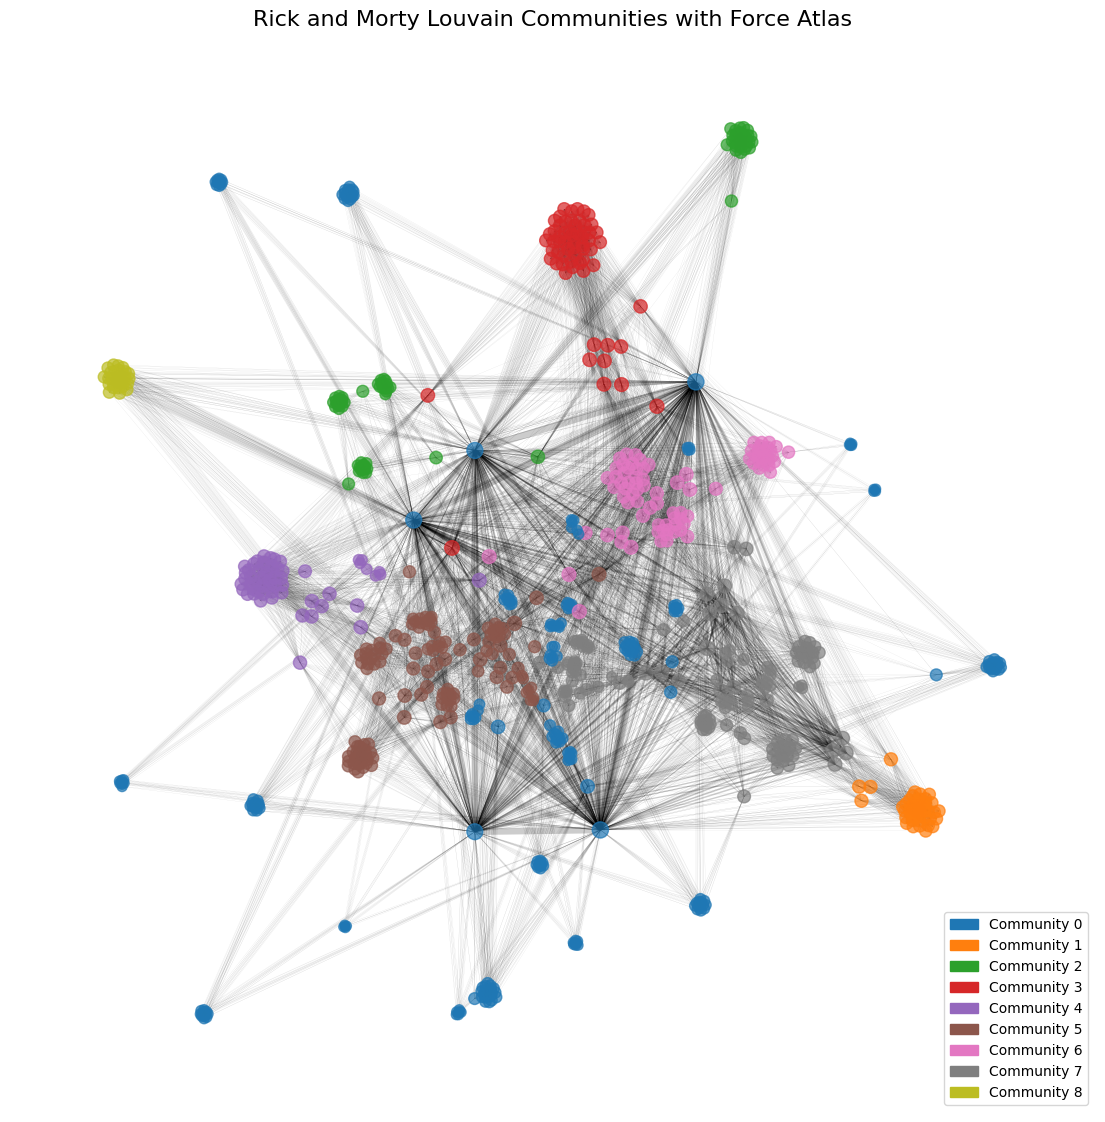

In [ ]:
partition = community_louvain.best_partition(G)

# Add community as a node attribute
nx.set_node_attributes(G, partition, "community")

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.5,  
    jitterTolerance=0.5,     
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=3.0,        
    strongGravityMode=False,
    gravity=3.0,            
    verbose=True
)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=3000)

distinct_colors = ListedColormap([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"
])
community_colors = {community_id: distinct_colors(community_id % len(distinct_colors.colors))
                    for community_id in set(partition.values())}
node_color = [community_colors[partition[node]] for node in G.nodes()]

degrees = dict(G.degree())
node_size = [np.log(degrees[node] + 1) * 20 for node in G.nodes()]  # Adjust scale factor
edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]

plt.figure(figsize=(14, 14))

nx.draw_networkx_nodes(G, positions, nodelist=list(positions.keys()), node_size=node_size,
                       node_color=node_color, alpha=0.7)

nx.draw_networkx_edges(G, positions, edge_color="black", alpha=0.2, width=[w * 0.1 for w in edge_weights])

patches = [mpatches.Patch(color=community_colors[c], label=f"Community {c}") for c in set(partition.values())]
plt.legend(handles=patches, loc="lower right", fontsize=10)

plt.title("Rick and Morty Louvain Communities with Force Atlas", fontsize=16)
plt.axis("off")
plt.show()


<div style="text-align: center; font-size: 14px">
    <em> <strong>Figure 2: Louvain communities </strong> <br> Visualization of communities identified by the Louvain algorithm. From the previously constructed network, 8 distinct communities are detected. Each node is color-coded based on its community, and darker edges indicate stronger relationships </em>
</div>


The visualization reveals distinct communities within the *Rick and Morty* network, with characters grouped based on shared appearances and interactions, highlighting the structure and diversity of relationships in the show. The darker the link, the stronger the connection.

In [48]:
community_sizes = Counter(partition.values())
print("Community sizes:")
for community_id, size in community_sizes.items():
    print(f'Community {community_id}: {size} nodes')

Community sizes:
Community 0: 263 nodes
Community 5: 128 nodes
Community 6: 86 nodes
Community 3: 62 nodes
Community 7: 133 nodes
Community 4: 58 nodes
Community 2: 79 nodes
Community 8: 31 nodes
Community 1: 43 nodes


The community sizes reveal a diverse distribution of nodes across the network, with Community 0 being the largest, containing 263 nodes, and Community 8 being the smallest, with only 31 nodes.

Let us look at the modularity score for the communities. 

## Part 2.2 Modularities

In [49]:
louvain_communities = {}
for node, community in partition.items():
    if community not in louvain_communities:
        louvain_communities[community] = []
    louvain_communities[community].append(node)
louvain_communities = list(louvain_communities.values())

# species communities
species_communities = {}
for node in G.nodes():
    species = G.nodes[node].get("species", "Unknown")
    if species not in species_communities:
        species_communities[species] = []
    species_communities[species].append(node)
species_communities = list(species_communities.values())

# type communities
type_communities = {}
for node in G.nodes():
    node_type = G.nodes[node].get("type", "Normal")
    if node_type not in type_communities:
        type_communities[node_type] = []
    type_communities[node_type].append(node)
type_communities = list(type_communities.values())

modularity_louvain = nx.algorithms.community.modularity(G, louvain_communities)
modularity_species = nx.algorithms.community.modularity(G, species_communities)
modularity_type = nx.algorithms.community.modularity(G, type_communities)

print(f"Modularity (Louvain): {modularity_louvain:.4f}")
print(f"Modularity (Species): {modularity_species:.4f}")
print(f"Modularity (Type): {modularity_type:.4f}")

Modularity (Louvain): 0.5262
Modularity (Species): 0.0996
Modularity (Type): 0.1243


- Louvain Modularity (0.5130):

The Louvain modularity is significantly higher than the modularity for species or type.
This indicates that the Louvain community detection algorithm effectively captures the underlying structure of the graph, grouping characters based on shared relationships or co-occurrences.

- Species Modularity (0.0996):

The modularity for species is quite low, suggesting that species-based partitioning does not align well with the graph's structure.
This result indicates that species is not a strong determinant of how characters are interconnected in the graph.

- Type Modularity (0.1243):

The modularity for type is slightly higher than species but still low overall.
While type may provide some insight into character relationships, it does not explain the structure of the graph as well as the Louvain partitioning.

The Louvain Partitioning provides the most accurate representation of the graph's community structure, likely capturing complex relationships and co-occurrences among characters.
Species and Type attributes, while important for character classification, appear to have limited influence on the connectivity patterns within the graph.
To conclude, character relationships in the network are more influenced by co-occurrences (captured by Louvain) rather than intrinsic attributes like species or type.

## Part 2.3: Attribute Correlation with Network Properties

We'll focus on three main points: 

- Analyzing Attribute Distribution Across Communities
- Correlating Attributes with Centrality Measures
- Visualizing Attribute Influence on Network Structure

100%|██████████| 2000/2000 [00:13<00:00, 151.96it/s]


BarnesHut Approximation  took  3.80  seconds
Repulsion forces  took  7.88  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.54  seconds
AdjustSpeedAndApplyForces step  took  0.47  seconds


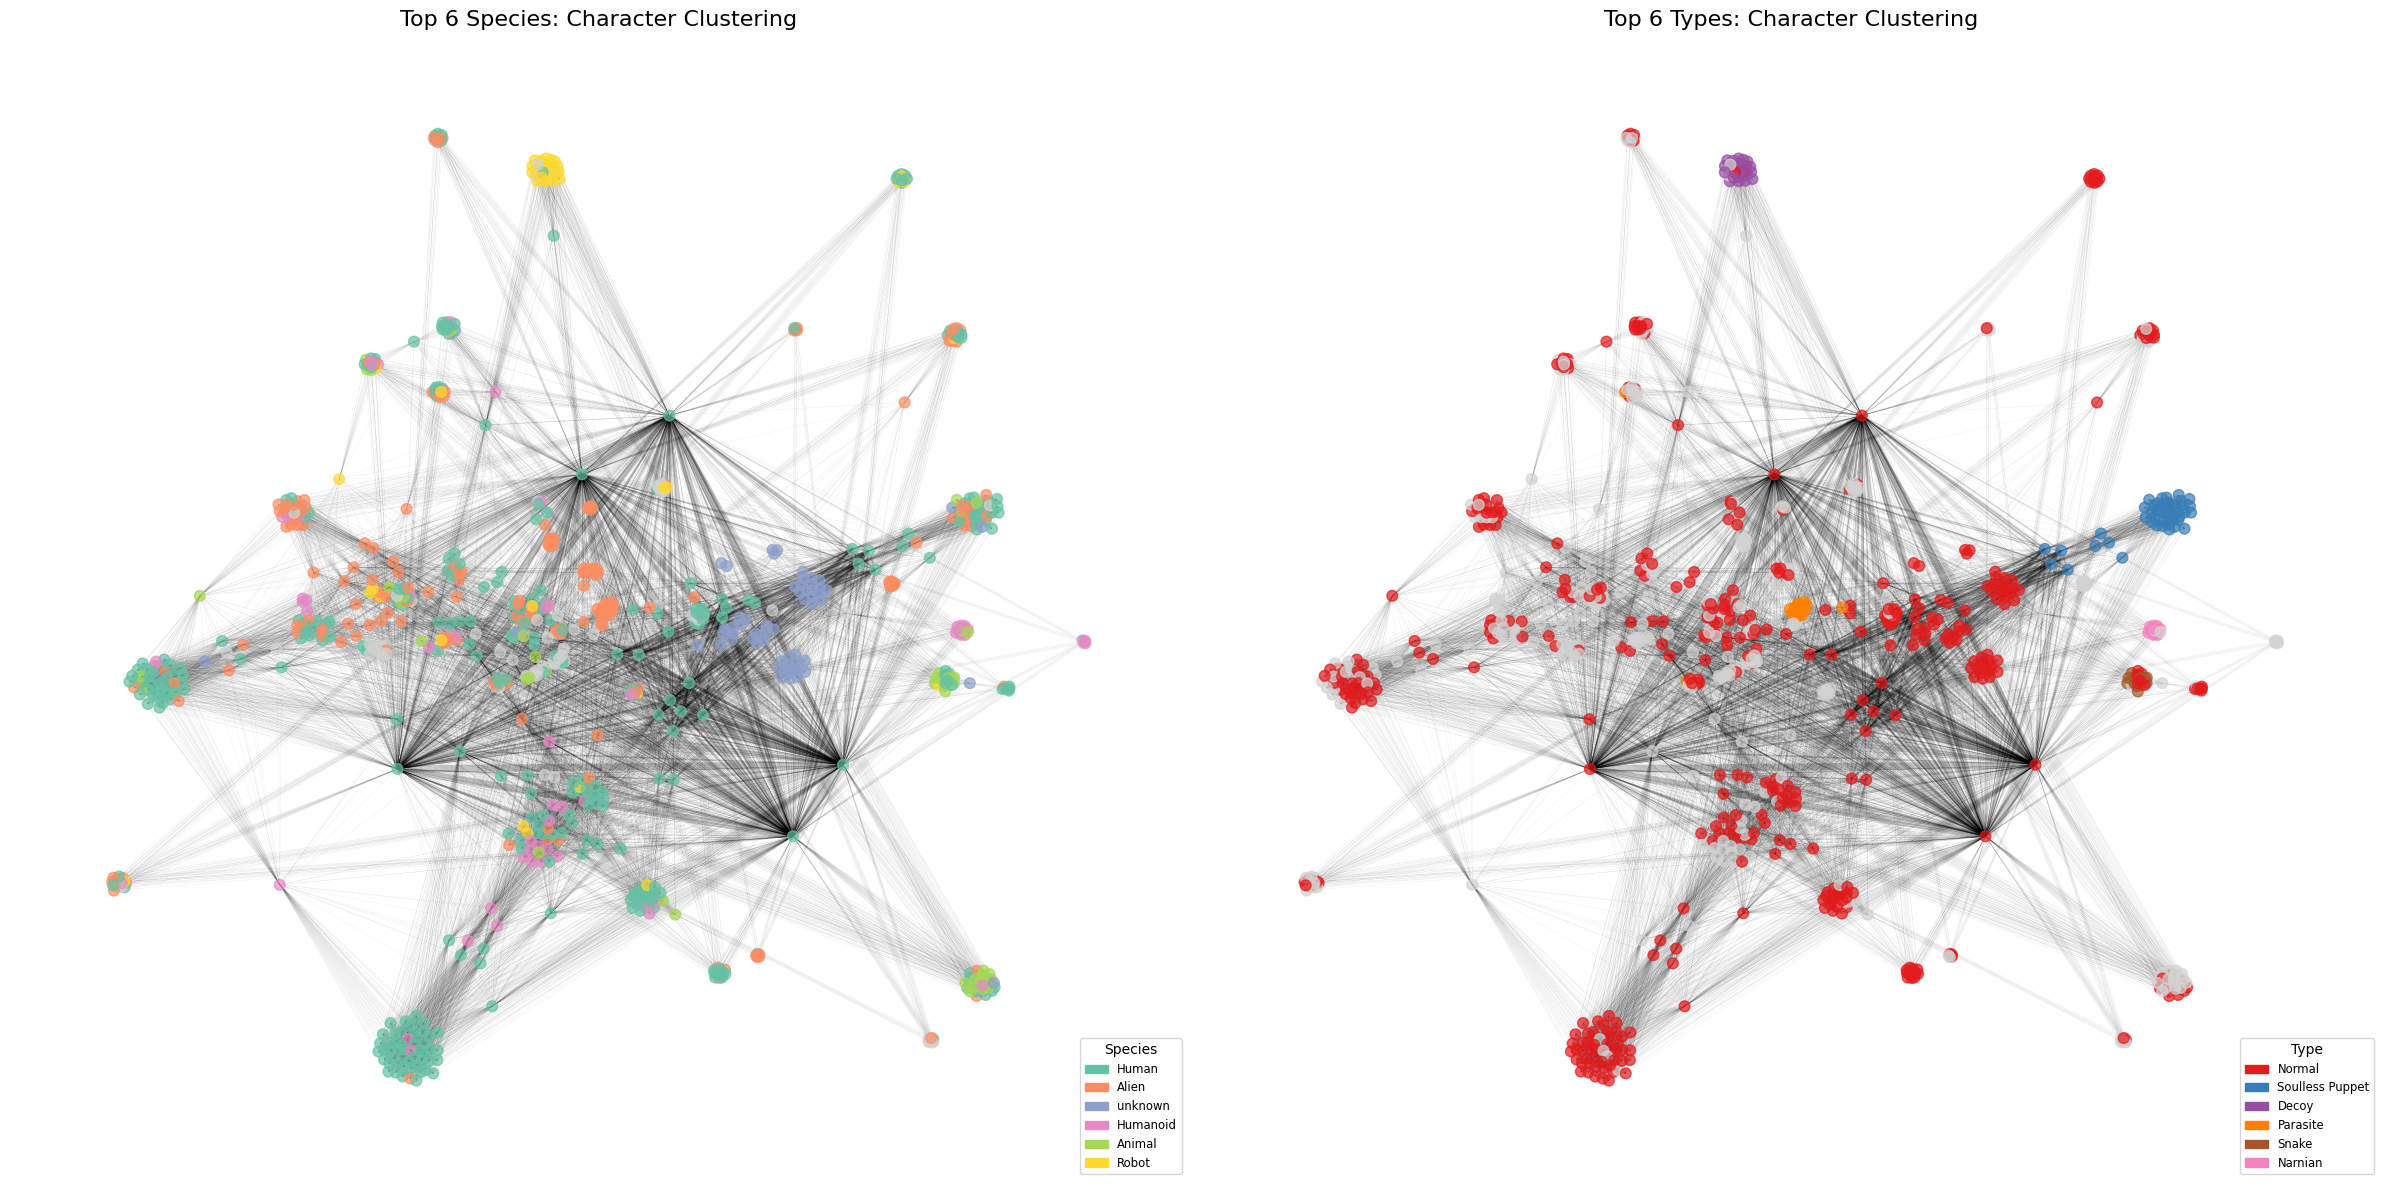

In [ ]:
top_species = (
    pd.Series(nx.get_node_attributes(G, "species")).value_counts().head(6).index.tolist()
)
top_types = (
    pd.Series(nx.get_node_attributes(G, "type")).value_counts().head(6).index.tolist()
)

filtered_nodes_species = [
    node for node in G.nodes() if G.nodes[node]["species"] in top_species
]
filtered_nodes_types = [
    node for node in G.nodes() if G.nodes[node]["type"] in top_types
]

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=2.0,
    verbose=True,
)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

species_colors = {species: plt.cm.Set2(i % 10) for i, species in enumerate(top_species)}
species_node_colors = [
    species_colors[G.nodes[node]["species"]] if node in filtered_nodes_species else "lightgray"
    for node in G.nodes()
]

type_colors = {node_type: plt.cm.Set1(i / len(top_types)) for i, node_type in enumerate(top_types)}
type_node_colors = [
    type_colors[G.nodes[node]["type"]] if node in filtered_nodes_types else "lightgray"
    for node in G.nodes()
]

edge_weights = [G[u][v].get("weight", 1) for u, v in G.edges()]
edge_widths = [w * 0.1 for w in edge_weights]

fig, axes = plt.subplots(1, 2, figsize=(24, 12))

axes[0].set_title("Top 6 Species: Character Clustering", fontsize=16)
nx.draw_networkx_nodes(
    G, positions, node_size=60, node_color=species_node_colors, alpha=0.7, ax=axes[0]
)
nx.draw_networkx_edges(
    G, positions, edge_color="black", alpha=0.2, width=edge_widths, ax=axes[0]
)
axes[0].axis("off")

species_legend_patches = [
    mpatches.Patch(color=color, label=species) for species, color in species_colors.items()
]
axes[0].legend(
    handles=species_legend_patches,
    loc="lower right",
    fontsize="small",
    title="Species",
    frameon=True,
)

axes[1].set_title("Top 6 Types: Character Clustering", fontsize=16)
nx.draw_networkx_nodes(
    G, positions, node_size=60, node_color=type_node_colors, alpha=0.7, ax=axes[1]
)
nx.draw_networkx_edges(
    G, positions, edge_color="black", alpha=0.2, width=edge_widths, ax=axes[1]
)
axes[1].axis("off")

type_legend_patches = [
    mpatches.Patch(color=color, label=node_type) for node_type, color in type_colors.items()
]
axes[1].legend(
    handles=type_legend_patches,
    loc="lower right",
    fontsize="small",
    title="Type",
    frameon=True,
)

plt.tight_layout()
plt.show()

<div style="text-align: center; font-size: 14px">
    <em> <strong> Figure 3: Character Clustering Based on Species and Type </strong> <br> The left graph illustrates the clustering of characters based on the top 6 most frequent species. Nodes are color-coded according to species, and darker edges indicate stronger relationships between characters. A light blue node indicates a lack of type <br> 
    The right graph shows the clustering of characters based on the top 6 most frequent types. Similar to the species-based clustering, nodes are colored by type, and darker edges signify stronger relationships. A light gray node indicates a lack of type </em>
</div>


The visualizations reveal distinct clustering patterns within the Rick and Morty character network. On the left, species-based clustering shows that humans dominate the network, followed by aliens, underscoring their significant roles in the series. This clustering also highlights the diversity of characters while showcasing interactions between different species.

On the right, type-based clustering demonstrates that humans are the dominant type. The visualization reveals a variety of clusters, with some types forming tightly-knit groups while others are more dispersed. Additionally, it can be seen that some clustering showcasing stronger connections. 

Let us compare the type of the characters with the louvain communities in a confusion matrix. 

## Part 2.4 Type of the Characters vs Louvain communities - Confusion Matrix

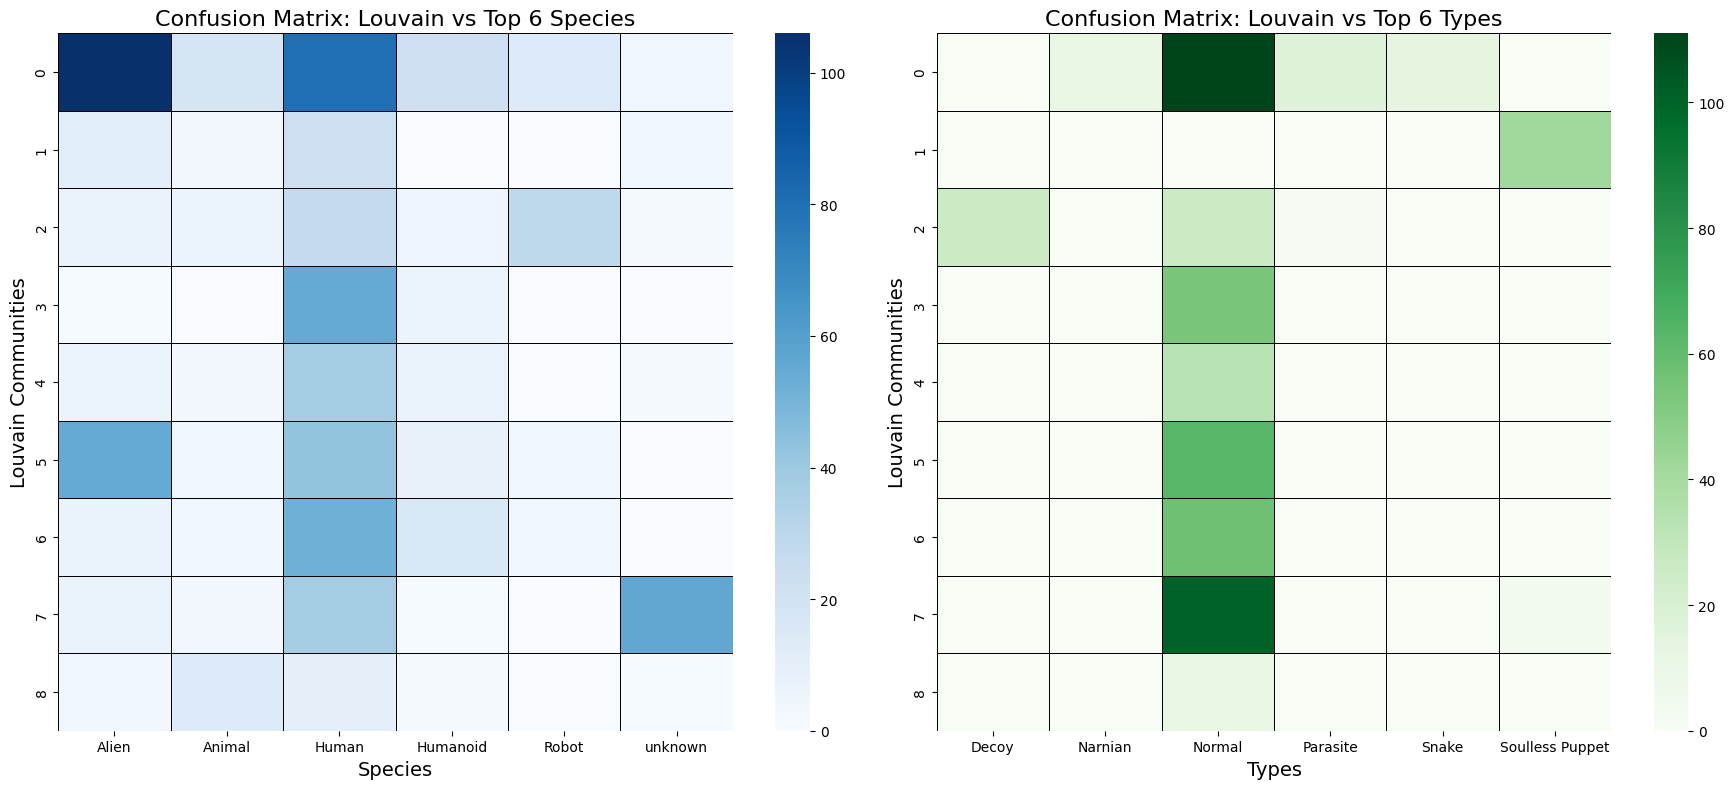

In [ ]:
node_data = [
    {
        "node": node,
        "louvain": partition[node], 
        "species": G.nodes[node].get("species", "Unknown"),
        "type": G.nodes[node].get("type", "Normal")
    }
    for node in G.nodes()
]

df_node_data = pd.DataFrame(node_data)

top_species = df_node_data["species"].value_counts().head(6).index.tolist()
top_types = df_node_data["type"].value_counts().head(6).index.tolist()

df_filtered_species = df_node_data[df_node_data["species"].isin(top_species)]
df_filtered_types = df_node_data[df_node_data["type"].isin(top_types)]

confusion_louvain_species = pd.crosstab(
    df_filtered_species["louvain"], df_filtered_species["species"]
)
confusion_louvain_types = pd.crosstab(
    df_filtered_types["louvain"], df_filtered_types["type"]
)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Louvain vs. Species
sns.heatmap(
    confusion_louvain_species,
    cmap="Blues",
    annot=False,
    cbar=True,
    linecolor="black",
    linewidths=0.5,
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix: Louvain vs Top 6 Species", fontsize=16)
axes[0].set_xlabel("Species", fontsize=14)
axes[0].set_ylabel("Louvain Communities", fontsize=14)

# Louvain vs. Types
sns.heatmap(
    confusion_louvain_types,
    cmap="Greens",
    annot=False,
    cbar=True,
    linecolor="black",
    linewidths=0.5,
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix: Louvain vs Top 6 Types", fontsize=16)
axes[1].set_xlabel("Types", fontsize=14)
axes[1].set_ylabel("Louvain Communities", fontsize=14)

plt.tight_layout()
plt.show()

<div style="text-align: center; font-size: 14px">
    <em> <strong> Figure 4: Confusion Matrices: Louvain Communities vs. Top 6 Species and Types </strong> <br> The left matrix compares the Louvain communities with the top 6 species, showcasing how species are distributed across the detected communities. <br> The right graph compares the Louvain communtiies with the top 6 types, also showcasing how types are distributed across detected communities. </em>
</div>


Community Centrality:

- In general, Louvain communities with a high frequency of humans are also predominantly associated with the normal type. However, community 3 is characterized almost exclusively by the human species and the normal type. Interestingly, while community 1 has the highest representation of the human species and normal type, it also displays an even greater prevalence of the alien species.

Peripheral Communities:
- Communities like 6, 7, and 8 represent more diverse and unique character traits (e.g., "Soulless Puppet," "Decoy"), reflecting episodic or subplot-driven narratives.

Species and Type Overlap:

- "Unknown" species and less frequent types like "Snake" and "Narnian" are clustered in smaller communities, highlighting their limited and specific roles.

Core vs Peripheral Structure:

- The heatmaps reveal a structural division between the central storyline (humans, normal types) and episodic arcs (aliens, robots, unique types), reinforcing the layered storytelling of "Rick and Morty."

# Part 3: NLP of episodes scripts

In another notebook there is the code used to scrape the transcripts, that is not going to be run here for a matter of time efficiency.

We use our folder with the scripts of the first 6 seasons. As mentioned earlier the 7th season has been voluntarily avoided as the transcription was very bad :(

In [ ]:
folder_path = "Rick_and_Morty_scripts"

all_seasons_data = []

# Iterate over all CSV files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        # Load the CSV into a DataFrame
        season_data = pd.read_csv(file_path, delimiter = ';', encoding='ANSI')
        all_seasons_data.append(season_data)

df_scripts = pd.concat(all_seasons_data, axis=0)

df_scripts.head()

Season  Episode Episode Name Character Name  \
0     1.0        1        Pilot           Rick   
1     1.0        1        Pilot          Morty   
2     1.0        1        Pilot           Rick   
3     1.0        1        Pilot          Morty   
4     1.0        1        Pilot           Rick   

                                            Dialogue  ï»¿Season  
0  Morty! You gotta come on. Jus'... you gotta co...        NaN  
1                       What, Rick? What’s going on?        NaN  
2                   I got a surprise for you, Morty.        NaN  
3  It's the middle of the night. What are you tal...        NaN  
4  Come on, I got a surprise for you.  Come on, h...        NaN

In [53]:
df_scripts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16774 entries, 0 to 2841
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Season          10912 non-null  float64
 1   Episode         16774 non-null  int64  
 2   Episode Name    16774 non-null  object 
 3   Character Name  16774 non-null  object 
 4   Dialogue        16770 non-null  object 
 5   ï»¿Season       5862 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 917.3+ KB


Let us handle the NaN and clean the dataframe.

In [54]:
# Fill NaN values in 'Season' with values from 'ï»¿Season'
df_scripts["Season"].fillna(df_scripts["ï»¿Season"], inplace=True)

# Drop the 'ï»¿Season' column
df_scripts.drop(columns=["ï»¿Season"], inplace=True, errors="ignore")

# Convert 'Season' to int
df_scripts["Season"] = df_scripts["Season"].astype(int)

df_scripts.head()

C:\Users\nba\AppData\Local\Temp\ipykernel_9196\1043036490.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_scripts["Season"].fillna(df_scripts["ï»¿Season"], inplace=True)


Season  Episode Episode Name Character Name  \
0       1        1        Pilot           Rick   
1       1        1        Pilot          Morty   
2       1        1        Pilot           Rick   
3       1        1        Pilot          Morty   
4       1        1        Pilot           Rick   

                                            Dialogue  
0  Morty! You gotta come on. Jus'... you gotta co...  
1                       What, Rick? What’s going on?  
2                   I got a surprise for you, Morty.  
3  It's the middle of the night. What are you tal...  
4  Come on, I got a surprise for you.  Come on, h...

In [55]:
df_scripts = df_scripts.astype({'Episode Name':'str','Character Name':'str','Dialogue':'str'})

Let's clean and format the text:
- Expand contractions: In English, it's common to omit vowels in a word to form contractions. Removing contractions helps normalize text, and it is useful when working with text-based data, as words play an important role in sentiment analysis.
- Remove punctuation marks: Remove punctuation marks from the text, such as ".?!" and also symbols like "@#$".
- Convert to lowercase: Convert the text to lowercase, such as turning "Hola" into "hola" or "HELLO" into "hola".
- Remove "Stop Words" (null/common words that should be ignored in the context).
- Remove irrelevant words using NLTK stop words like "is, the, a," etc., from the dialogues, as they do not add any information or meaning.
- Remove numbers and non-alphabetical tokens.
- Remove numbers from the text, such as "1, 2, 3, 4, 5..." and other tokens or words that are not alphabetical. Numbers and other characters are typically removed when performing text classification or extracting key phrases since they don't hold much significance for identifying the main words.

In [ ]:
nltk.download('stopwords')

def clean_text(text):
    text_expanded = contractions.fix(text)
    text_expanded = text_expanded.lower()
    text_nopoints = text_expanded.translate(str.maketrans('', '', string.punctuation))
    text_nospace = ' '.join(text_nopoints.split())
    stopwords_en = set(stopwords.words('english'))
    words_no_stopword = [word for word in text_nospace.split() if word not in stopwords_en]
    words_no_number = [word for word in words_no_stopword if word.isalpha()]
    clean_text = ' '.join(words_no_number)
    
    return clean_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


After cleaning and formatting, the text can be processed into unigrams, bigrams, and trigrams. The function first calls clean() to remove punctuation, extra spaces, stopwords, and numbers. It then creates unigrams by splitting the cleaned text into individual words.

To generate bigrams, the function loops through the unigrams, creating strings of two consecutive words, which are added to the bigrams list.
Similarly, trigrams are created by grouping three consecutive words.
Finally, the function returns three lists: unigrams, bigrams, and trigrams of the cleaned text.

In [ ]:
def process_text(text):
    cleaned_text = clean_text(text)
    
    # Create unigrams
    unigrams = cleaned_text.split()
    
    # Create bigrams
    bigrams = []
    for i in range(len(unigrams)-1):
        bigrams.append(unigrams[i] + ' ' + unigrams[i+1])
    
    # Create trigrams
    trigrams = []
    for i in range(len(unigrams)-2):
        trigrams.append(unigrams[i] + ' ' + unigrams[i+1] + ' ' + unigrams[i+2])
    
    return {'bigrams': bigrams, 'trigrams': trigrams}

In [ ]:
# Create a new DataFrame derived from the original, with three new columns for bigrams and trigrams
df_processed = pd.DataFrame(df_scripts['Dialogue'].apply(lambda x: process_text(x)).tolist())

df_scripts_reset = df_scripts.reset_index(drop=True)
df_processed_reset = df_processed.reset_index(drop=True)
df_final = pd.concat([df_scripts_reset, df_processed_reset], axis=1)

df_final.head(6)

Season  Episode Episode Name Character Name  \
0       1        1        Pilot           Rick   
1       1        1        Pilot          Morty   
2       1        1        Pilot           Rick   
3       1        1        Pilot          Morty   
4       1        1        Pilot           Rick   
5       1        1        Pilot          Morty   

                                            Dialogue  \
0  Morty! You gotta come on. Jus'... you gotta co...   
1                       What, Rick? What’s going on?   
2                   I got a surprise for you, Morty.   
3  It's the middle of the night. What are you tal...   
4  Come on, I got a surprise for you.  Come on, h...   
5                Ow! Ow! You're tugging me too hard!   

                                             bigrams  \
0  [morty got, got come, come jus, jus got, got c...   
1                                       [rick going]   
2                     [got surprise, surprise morty]   
3                      [middle night, night talking]   
4  [come got, got surprise, surprise come, come h...   
5                  [ow ow, ow tugging, tugging hard]   

                                            trigrams  
0  [morty got come, got come jus, come jus got, j...  
1                                                 []  
2                               [got surprise morty]  
3                             [middle night talking]  
4  [come got surprise, got surprise come, surpris...  
5                   [ow ow tugging, ow tugging hard]

In [ ]:
def tokenize_words(dataframe):
    dataframe["Dialogue"] = dataframe["Dialogue"].apply(lambda x: clean_text(x))
    dataframe['Words'] = dataframe['Dialogue'].apply(nltk.word_tokenize)
    new_rows = []
    
    for index, row in dataframe.iterrows():
        tokens = row['Words']
        for token in tokens:
            new_rows.append([row['Character Name'], token])    
    new_dataframe = pd.DataFrame(new_rows, columns=['Character Name', 'Word'])
    
    return new_dataframe

In [60]:
# Splitting dialogues of every character into words
scripts_tokenized = tokenize_words(df_scripts)

scripts_tokenized.tail(6)

Character Name     Word
98070  Mr. Poopybutthole     love
98071  Mr. Poopybutthole    phone
98072  Mr. Poopybutthole  blocked
98073  Mr. Poopybutthole   youuse
98074  Mr. Poopybutthole   ooweee
98075  Mr. Poopybutthole   broken

Using the words of each character to create a wordcloud showcasing the words. 

## Part 3.1: Wordclouds

In [ ]:
# mask for visualizing word clouds
portal_mask = np.array(Image.open("Images/portal.png"))

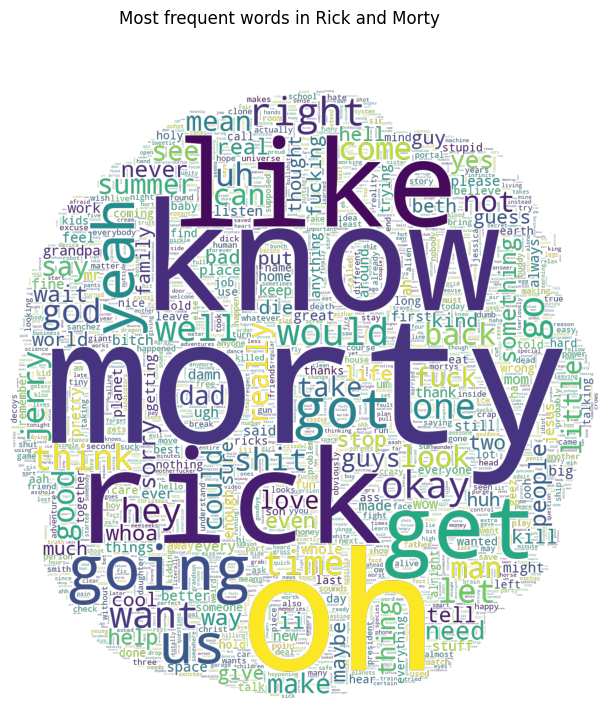

In [ ]:
word_counts = scripts_tokenized['Word'].value_counts()

wordcloud = WordCloud(mode = 'RGBA', width=400, height=400, background_color=None, mask=portal_mask, max_words=len(scripts_tokenized)).generate_from_frequencies(word_counts)

fig, ax1 = plt.subplots(1, figsize=(20, 8))
fig.suptitle("Most frequent words in Rick and Morty")
ax1.imshow(wordcloud)
ax1.axis('off')

plt.show()

<div style="text-align: center; font-size: 14px">
    <em> <strong>Figure 5: Word Cloud Representation of Most Frequent Words</strong> <br> The word cloud visually represents the most frequently used words in the dataset. Larger font sizes indicate higher word frequency, with "Rick," "Morty," "know," and "like" being the most prominent. </em>
</div>


- "Morty" and "Rick" are front and center:

Of course! These two are the heart of the show. Morty is everywhere here, which makes sense—he’s always caught in the mess Rick creates. Rick, being the mad genius he is, is just a bit more spread out. Their names really reflect their central roles as the ultimate duo in this wild, dimension-hopping saga.

- "Know," "like," and "going":

Classic Morty vibes. Morty’s always questioning things like, "What the hell is going on, Rick?" or trying to wrap his head around the insanity that Rick drags him into. "Like" and "know" are those filler words you hear throughout, especially when Morty is just trying to hold it together during one of Rick’s absurd speeches.

- "Shit" and other strong words:

Oh yeah, the cursing. It’s Rick and Morty. You can’t have these two without a healthy dose of profanities, and "shit" is just a staple. Honestly, it’s like Morty’s first word after "Rick" when he’s overwhelmed by whatever out-of-this-world, messed-up thing they’re getting into.

- "Okay," "want," "make," and "you":

Morty’s desperation and frustration come through here—those "okay"s when he’s about to get pulled into a crazy plan, or the "want" when he’s trying to have a normal life, but no, Rick’s dragging him to another dimension. “Make” shows the chaos Rick causes when trying to manipulate reality for his own amusement (or selfish reasons).

- "Yeah" and "let’s":

Can you hear it? Morty’s constant, semi-lost “yeah, sure, Rick…” or Rick’s calm “let’s do this, Morty.” These words are all about those iconic exchanges where Morty, while freaking out, still follows Rick into the unknown, even when it’s clear they’re about to deal with something horrifically bizarre.

Let us dive a bit deeper into the bigrams and trigrams to see the most common used ones.

## Part 3.2: Bigrams and Trigrams

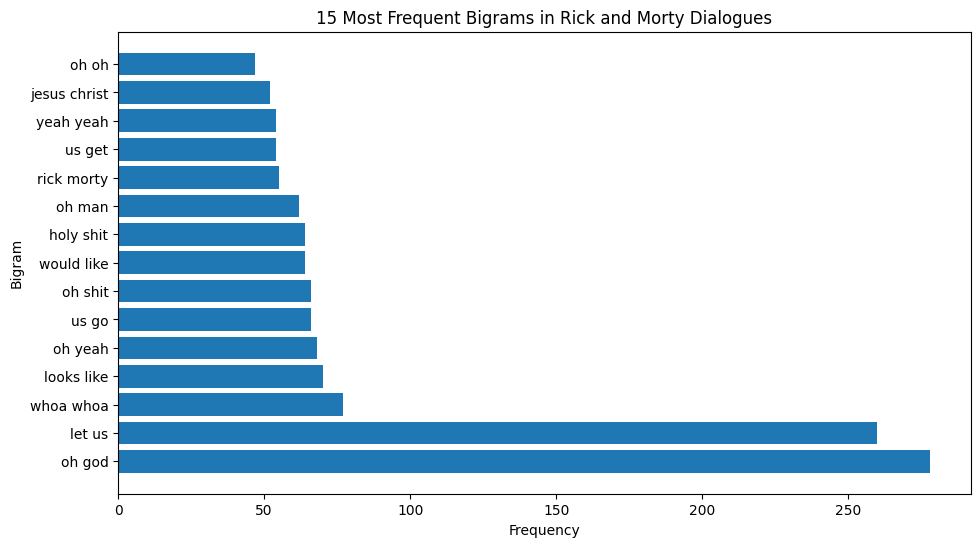

In [63]:
bigram_freq = FreqDist([bg for row in df_final['bigrams'] for bg in row])

# 15 bigramas more frequent
frequent_bigrams = bigram_freq.most_common(15)

plt.figure(figsize=(11, 6))
plt.barh([x[0] for x in frequent_bigrams], [x[1] for x in frequent_bigrams])
plt.title("15 Most Frequent Bigrams in Rick and Morty Dialogues")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()

<div style="text-align: center; font-size: 14px">
    <em> <strong> Figur 6: 15 most frequent Bigrams </strong> <br> The figure displays the 15 most common bigrams found in the dialogues. </em>
</div>


**Figur 6** illustrates the 15 most frequent bigrams used in Rick and Morty dialogues. The two most common bigrams, let us and oh god, stand out with over 250 occurrences each, highlighting their recurring use in the show. In contrast, the remaining bigrams, such as whoa whoa and looks like, are used significantly less, with frequencies below 100. This disparity emphasizes the repetitive nature of certain phrases, reflecting character habits or catchphrases.

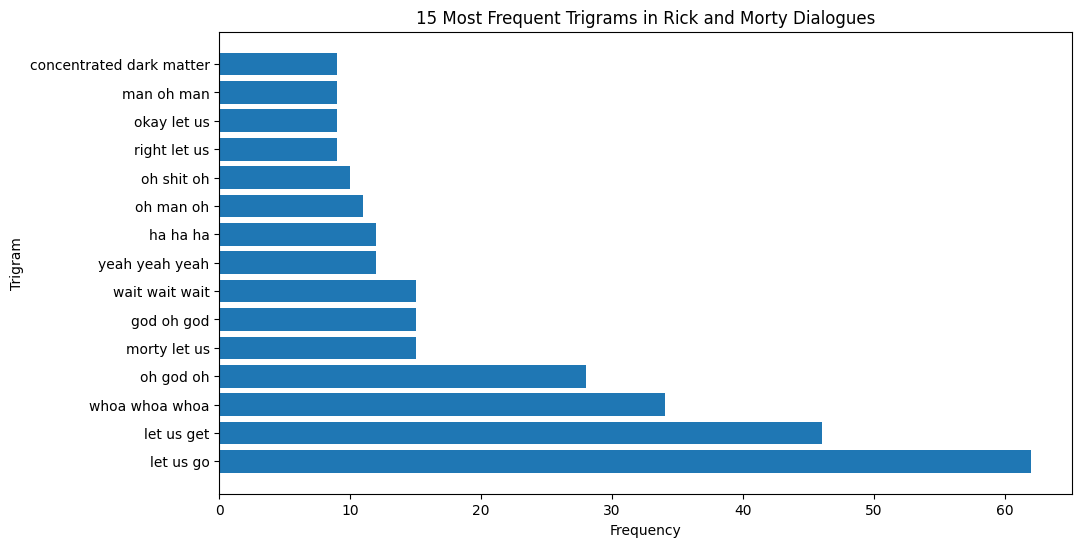

In [64]:
trigram_freq = FreqDist([tg for row in df_final['trigrams'] for tg in row])

# 15 trigrams more frequent
frequent_trigrams = trigram_freq.most_common(15)

plt.figure(figsize=(11, 6))
plt.barh([x[0] for x in frequent_trigrams], [x[1] for x in frequent_trigrams])
plt.title("15 Most Frequent Trigrams in Rick and Morty Dialogues")
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.show()

<div style="text-align: center; font-size: 14px">
    <em> <strong> Figur 7: 15 most frequent Trigrams </strong> <br> The figure displays the 15 most common Trigrams found in the dialogues. </em>
</div>


**Figure 7** illustrates the 15 most frequent trigrams found in the dialogues. The frequency of trigrams is noticeably lower compared to bigrams, with the most repetitive trigram appearing around 80 times. Interestingly, the _let us_ bigram features prominently in several trigrams, which aligns with its dominance in **Figure 6**. This observation highlights the contextual significance of _let us_ in the dialogues.

In this case, the most frequent trigrams include _oh god oh_, _whoa whoa whoa_, _let us get_, and _let us go_. These results align well with the findings from **Figure 6**, demonstrating the consistent use of repetitive and expressive phrases throughout the series' dialogues.

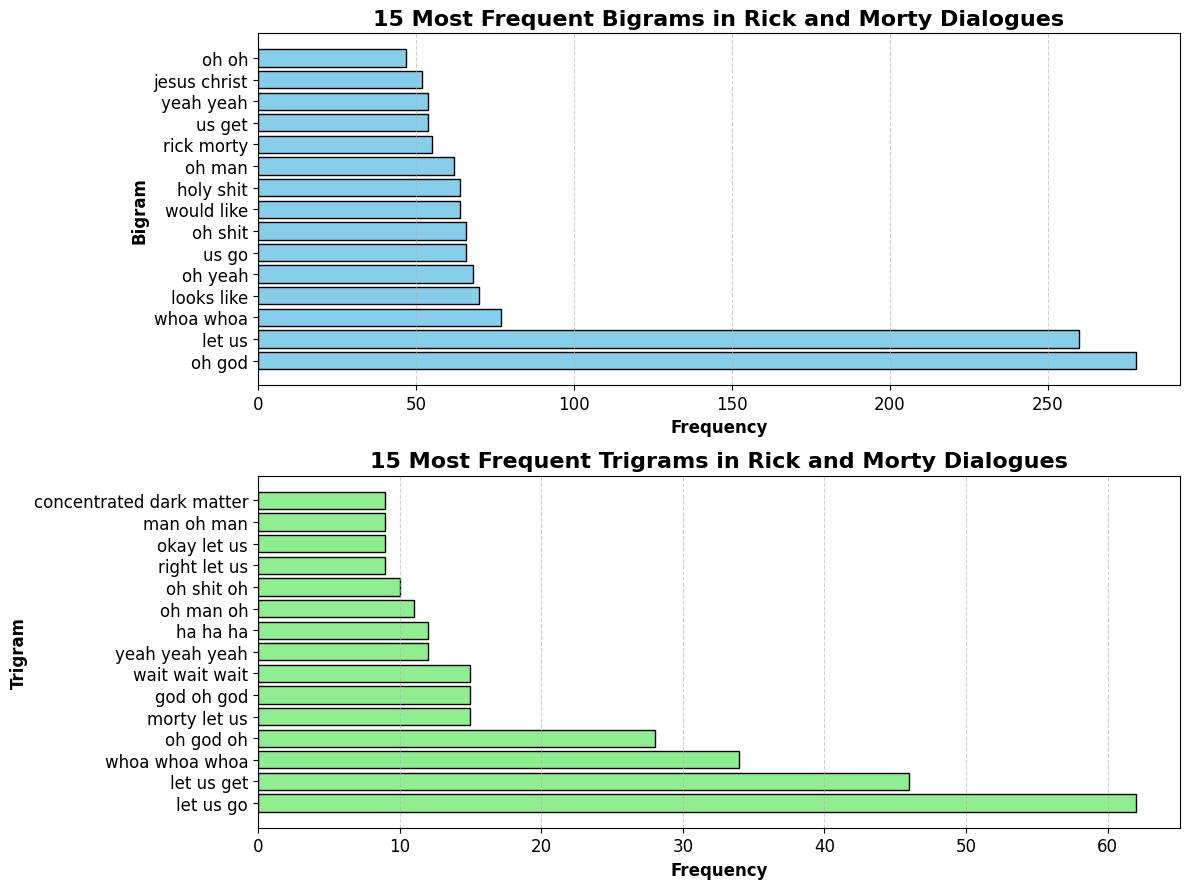

In [ ]:
# frequency distribution for bigrams
bigram_freq = FreqDist([bg for row in df_final['bigrams'] for bg in row])

# 15 most frequent bigrams
frequent_bigrams = bigram_freq.most_common(15)

# frequency distribution for trigrams
trigram_freq = FreqDist([tg for row in df_final['trigrams'] for tg in row])

# 15 most frequent trigrams
frequent_trigrams = trigram_freq.most_common(15)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))

ax1.barh([x[0] for x in frequent_bigrams], [x[1] for x in frequent_bigrams], color='skyblue', edgecolor='black')
ax1.set_title("15 Most Frequent Bigrams in Rick and Morty Dialogues", fontsize=16, fontweight='bold')
ax1.set_xlabel("Frequency", fontsize=12, fontweight='bold')
ax1.set_ylabel("Bigram", fontsize=12, fontweight='bold')
ax1.grid(axis='x', linestyle='--', alpha=0.6)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_facecolor('white')

ax2.barh([x[0] for x in frequent_trigrams], [x[1] for x in frequent_trigrams], color='lightgreen', edgecolor='black')
ax2.set_title("15 Most Frequent Trigrams in Rick and Morty Dialogues", fontsize=16, fontweight='bold')
ax2.set_xlabel("Frequency", fontsize=12, fontweight='bold')
ax2.set_ylabel("Trigram", fontsize=12, fontweight='bold')
ax2.grid(axis='x', linestyle='--', alpha=0.6)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_facecolor('white')

plt.subplots_adjust(hspace=0.3)

plt.tight_layout()
plt.show()


<div style="text-align: center; font-size: 14px">
    <em> <strong>Figure 8: Word Cloud Representation of Top 15 Frequent Bigrams and Trigrams</strong> <br> The word cloud visually represents the most frequently used words in the dataset. Larger font sizes indicate higher word frequency, with "Rick," "Morty," "know," and "like" being the most prominent. </em>
</div>


**Figure 8** presents a side-by-side comparison of the results from **Figures 6 and 7**, highlighting the frequencies of bigrams and trigrams in the dialogues. It is evident that trigrams occur less frequently than bigrams. Naturally, the longer the sentences the less it happens that you use that exact sentence again. Notably, let us and oh god appear consistently across multiple trigrams, whereas they are combined into singular bigrams. 

## Part 3.3: Emotions and insights from the dialogues

When it comes to analyze the sentiments and emotions of the dialogues, we decided to procedd not using the labmt text file, and opt instead to the NRC Lexicon package. This will allow us to analyze in a more granular way the different emotions intead of just knowing if the dialogues are more or less happy on a quantitative level.

The NRC Emotions Lexicon is able to read two sentiments (positive and negative) and 8 emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust). Is going to be faster and 'plug and play', compared to the labmt list.

In [ ]:
def get_sentiments(scripts_tokenized):
    sentiments = ['positive', 'negative', 'anger','anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
    rows = []

    for index, row in scripts_tokenized.iterrows():
        word = NRCLex(row['Word'])
        emotions = word.affect_frequencies
        new_dict = {'Word': row['Word']}
        for emotion in emotions:
            new_dict[emotion] = emotions[emotion]
        
        rows.append(new_dict)

    sentiments_df = pd.DataFrame(rows, columns=['Word'] + sentiments)
    sentiments_df.fillna(0, inplace=True)

    if 'anticip' in sentiments_df.columns:
        sentiments_df.drop(columns='anticip', inplace=True)

    return sentiments_df

In [67]:
scripts_sentiments = get_sentiments(scripts_tokenized)

scripts_sentiments.head()

Word  positive  negative  anger  anticipation  disgust  fear  joy  \
0  morty       0.0       0.0    0.0           0.0      0.0   0.0  0.0   
1    got       0.0       0.0    0.0           0.0      0.0   0.0  0.0   
2   come       0.0       0.0    0.0           0.0      0.0   0.0  0.0   
3    jus       0.0       0.0    0.0           0.0      0.0   0.0  0.0   
4    got       0.0       0.0    0.0           0.0      0.0   0.0  0.0   

   sadness  surprise  trust  
0      0.0       0.0    0.0  
1      0.0       0.0    0.0  
2      0.0       0.0    0.0  
3      0.0       0.0    0.0  
4      0.0       0.0    0.0

In [68]:
def binar(x):
    if x != 0:
        return 1
    else:
        return 0
    
scripts_sentiments_binar = scripts_sentiments.drop(columns='Word',axis=0)
scripts_sentiments_binar = scripts_sentiments_binar.applymap(binar)

C:\Users\nba\AppData\Local\Temp\ipykernel_9196\2181199198.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  scripts_sentiments_binar = scripts_sentiments_binar.applymap(binar)


In [69]:
# Sum value 1 for columns
sum_sentiments = scripts_sentiments_binar.sum()

# new df with sums
scripts_total_sentiments = pd.DataFrame({'Sentiment': sum_sentiments.index, 'Total Words': sum_sentiments.values})

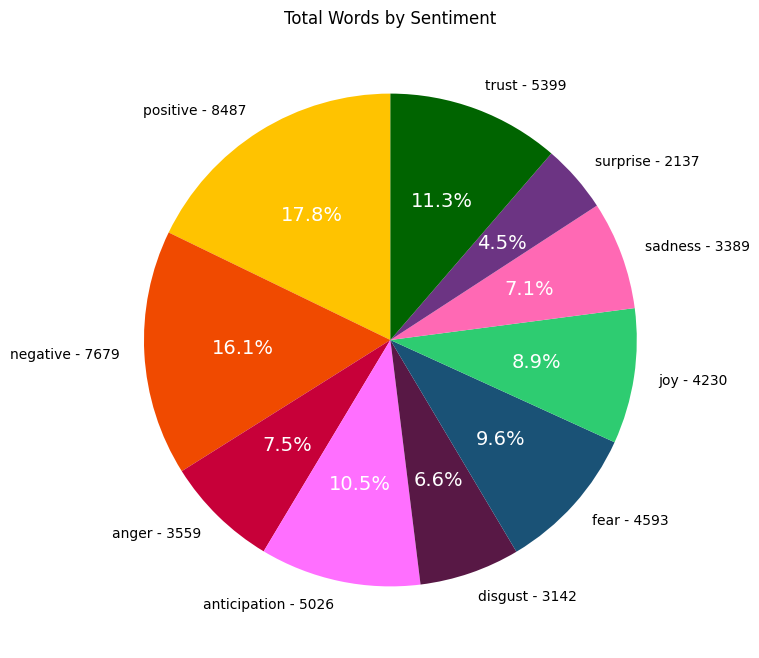

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

labels = scripts_total_sentiments["Sentiment"]
sizes = scripts_total_sentiments["Total Words"]

colors = ['#FFC300','#F04A00', '#C70039', '#FF6FFF', '#581845', '#1A5276', '#2ECC71', '#FF69B4', '#6C3483', '#006400']
patches, texts, autotexts = ax.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_color('white')

ax.set_title("Total Words by Sentiment")

for i, text in enumerate(texts):
    text.set_text("{} - {}".format(text.get_text(), sizes[i]))

plt.show()

<div style="text-align: center; font-size: 14px">
    <em> <strong>Figure 9: Distribution of Total Words by Sentiment</strong> <br>
    The pie chart illustrates the distribution of words across different sentiment categories, while also displaying the exact number of words in each category.
    </em>
</div>


**Figure 9** illustrates the distribution of words by sentiment, providing insights into the emotional tone of the dataset. Positive sentiment (17.8%) is the most prominent, closely followed by negative sentiment (16.1%), indicating a relatively balanced emotional landscape. Among specific emotions, trust (11.3%) and anticipation (10.5%) are highly represented, suggesting an optimistic or forward-looking tone.

On the other hand, fear (9.6%) and joy (8.9%) also play significant roles, highlighting contrasting emotional experiences. Emotions like anger (7.5%) and sadness (7.1%) contribute moderately, while surprise (4.5%) and disgust (6.6%) have the lowest representation. This distribution showcases a complex mix of emotional expressions, with a slight emphasis on positivity and trust, reflecting a nuanced emotional narrative.

The pie chart highlights the distribution of words within each sentiment category. Let’s take a closer look at each emotion to uncover its top 5 most frequently used words.

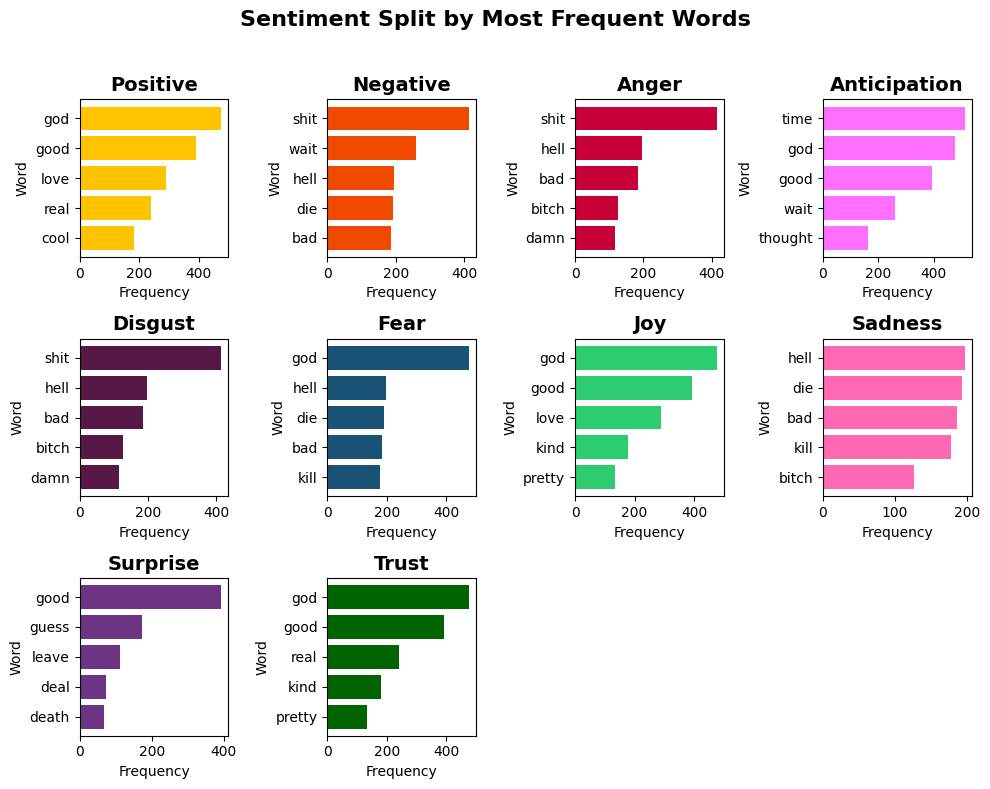

In [ ]:
def most_frequent_words_per_sentiment(scripts_tokenized, sentiments, top_n=10):
    # Dictionary to store words grouped by sentiment
    sentiment_words = {sentiment: [] for sentiment in sentiments}

    for index, row in scripts_tokenized.iterrows():
        word = row['Word']
        nrc_lex = NRCLex(word)
        for sentiment in sentiments:
            if nrc_lex.affect_frequencies.get(sentiment, 0) > 0:  # Check if the word has an association
                sentiment_words[sentiment].append(word)
    
    top_words_by_sentiment = {
        sentiment: Counter(sentiment_words[sentiment]).most_common(top_n)
        for sentiment in sentiments
    }

    return top_words_by_sentiment

def plot_sentiment_words_grid(top_words_by_sentiment):
    fig, axes = plt.subplots(3, 4, figsize=(10, 8))
    axes = axes.flatten()
    colors = ['#FFC300','#F04A00', '#C70039', '#FF6FFF', '#581845', '#1A5276', '#2ECC71', '#FF69B4', '#6C3483', '#006400']

    for i, (sentiment, word_counts) in enumerate(top_words_by_sentiment.items()):
        words, counts = zip(*word_counts) 
        axes[i].barh(words, counts, color=colors[i % len(colors)])
        axes[i].set_title(sentiment.capitalize(), fontsize=14, weight='bold')
        axes[i].set_xlabel('Frequency', fontsize=10)
        axes[i].set_ylabel('Word', fontsize=10)
        axes[i].invert_yaxis() 

    # Hide any unused subplots (if less than 9 emotions)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle('Sentiment Split by Most Frequent Words', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

sentiments = scripts_total_sentiments["Sentiment"]

top_words_by_sentiment = most_frequent_words_per_sentiment(scripts_tokenized, sentiments, top_n=5)
plot_sentiment_words_grid(top_words_by_sentiment)

<div style="text-align: center; font-size: 14px">
    <em> <strong>Figure 10: Sentiment split by most frequent words</strong> <br>     
    The top 5 most frequently used words in each sentiment category are displayed along with their respective frequencies.</em>
</div>


As fans of *Rick and Morty* would expect, the sentiment analysis reflects the show’s distinctive language and tone. Words like "shit" and "hell" dominate categories such as negative, anger, disgust, and sadness, underscoring the frequent use of crude or intense expressions in the dialogue. On the other hand, words like "god" appear across multiple sentiments, such as trust, fear, and even joy, reflecting its varied usage in different contexts within the show.

Positive sentiments feature words like "good" and "real," often associated with uplifting or affirming moments, while anticipation includes words like "time" and "thought," suggesting forward-looking or reflective dialogues. Words like "love" and "kind" stand out in joy, adding balance to the narrative’s emotional spectrum. This analysis highlights the mix of intense, humorous, and heartfelt expressions that are characteristic of *Rick and Morty*. 

Now, it would be interesting to understand which is the predominant emotion for the characters that speak the most, so obviously the Smith-Sanchez family... and who?

In [ ]:
character_word_counts = scripts_tokenized['Character Name'].value_counts()
top_characters = character_word_counts.head(10)
print(top_characters)

Character Name
Rick              29251
Morty             13607
Jerry              6692
Summer             5109
Beth               4742
President          1842
Space Beth          656
Pickle Rick         592
Mr. Goldenfold      466
Jessica             442
Name: count, dtype: int64


In [ ]:
def get_character_emotions(scripts_tokenized, top_characters):
    emotions = ['positive', 'negative', 'anger','anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
    character_emotions = {character: {emotion: 0 for emotion in emotions} for character in top_characters.index}
    
    # Iterate through the tokenized scripts and accumulate emotion scores for the top characters
    for index, row in scripts_tokenized.iterrows():
        character = row['Character Name']
        if character in top_characters.index:
            word = row['Word']
            nrc_lex = NRCLex(word)
            emotion_frequencies = nrc_lex.affect_frequencies
            for emotion in emotions:
                character_emotions[character][emotion] += emotion_frequencies.get(emotion, 0)
    
    return character_emotions

character_emotions = get_character_emotions(scripts_tokenized, top_characters)
emotion_df = pd.DataFrame(character_emotions).T
print(emotion_df)

                   positive     negative       anger  anticipation  \
Rick            1333.183333  1070.529762  317.442857    718.372619   
Morty            506.864286   437.261905  142.226190    273.746429   
Jerry            325.494048   218.463095   55.972619    165.561905   
Summer           234.876190   176.188095   52.214286    117.914286   
Beth             244.029762   174.298810   50.167857    114.113095   
President         87.870635    74.527778   23.359524     44.787302   
Space Beth        24.850000    30.183333    8.516667     17.100000   
Pickle Rick       28.800000    34.992857    5.076190      9.692857   
Mr. Goldenfold    27.009524    12.759524    4.902381      9.700000   
Jessica           22.126190     6.826190    3.992857     19.650000   

                   disgust        fear         joy     sadness    surprise  \
Rick            304.534524  399.585714  335.850000  267.865476  238.738095   
Morty           137.626190  207.548810  127.614286  129.921429  103.54761

Since Rick has the highest word count, it’s natural for his scores to be higher across all categories. However, this makes it challenging to observe overall patterns and compare different characters. For a better overview and easier comparison, we will normalize the emotion scores.

In [ ]:
emotions = emotion_df.columns.tolist()
normalized_emotion_df = emotion_df.div(top_characters, axis=0)

fig = go.Figure()

for character in normalized_emotion_df.index:
    fig.add_trace(go.Scatterpolar(
        r=normalized_emotion_df.loc[character].values,
        theta=emotions,
        fill='toself',
        name=character
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, normalized_emotion_df.values.max()]
        )),
    showlegend=True,
    title="Normalized Emotional Distribution of Top Characters"
)

fig.show()

<div style="text-align: center; font-size: 14px">
    <em> <strong>Figure 11: Normalized Emotional distribution</strong> <br>
    The words spoken by the top 10 most talkative characters have been normalized to provide a clearer overview, allowing for a better comparison of the sentiment categories their words fall into.</em>
</div>


**Figure 11** presents the normalized emotional distribution for the top characters, offering insights into their dominant emotional expressions. The interactive feature allows users to toggle character visibility by clicking their names removing their scores from the chart. 

Overall, most characters score highest in the positive and negative emotion categories. Notably, Pickle Rick stands out with the highest score for negative emotions, while Mr. Goldenfold achieves the highest normalized score for positive emotions. Jessica emerges as a unique character, scoring prominently in anticipation, highlighting her distinct emotional tone in the series.

If we focus on characters other than the dominant ones, we observe a consistent pattern where the majority of scores fall within the negative and positive emotion categories. This suggests that the language used by these characters often reflects a blend of optimism and conflict. Furthermore, their scores for other categories, such as trust, fear, and sadness, indicate a diverse emotional range. However, the differences in these scores between characters are less significant compared to the positive and negative categories.

Comparing Rick and Morty, their sentiment scores across categories are relatively close, with Rick showing slightly higher scores in positive, negative, trust, and anticipation categories. This could be due to Rick's having a higher word count than Morty.

The visualization highlights the emotional diversity in *Rick and Morty* while showcasing patterns that align with the unique personalities and roles of the characters.

# Part 4: Sentiments in Communities and Species

For our last analysis, we will check which are the most frequent emotions in the Louvain Communities and the species. This will be performed always with the package NRC Lexicon and the sentiment 'positive' and 'negative' will be excluded, in order to gather more insights from just the emotions.
The challenging part will be matching the community in the df scripts_tokenized, because the different forms of the characters and how the names are typed is different.

In [ ]:
scripts_tokenized["Normalized Name"] = scripts_tokenized["Character Name"].str.strip().str.lower()

graph_name_mapping = {
    attributes["name"].strip().lower(): node
    for node, attributes in G.nodes(data=True)
}

# Map communities using normalized names
scripts_tokenized["Community"] = scripts_tokenized["Normalized Name"].apply(
    lambda x: G.nodes[graph_name_mapping[x]]["community"] if x in graph_name_mapping else None
)

# Check if the mapping worked
print(scripts_tokenized[["Character Name", "Normalized Name", "Community"]].head())

  Character Name Normalized Name  Community
0           Rick            rick        NaN
1           Rick            rick        NaN
2           Rick            rick        NaN
3           Rick            rick        NaN
4           Rick            rick        NaN


In [ ]:
scripts_tokenized["Normalized Name"] = scripts_tokenized["Character Name"].str.strip().str.lower()

graph_name_mapping = {
    attributes["name"].strip().lower(): node
    for node, attributes in G.nodes(data=True)
}

# Map communities using normalized names
scripts_tokenized["Species"] = scripts_tokenized["Normalized Name"].apply(
    lambda x: G.nodes[graph_name_mapping[x]]["species"] if x in graph_name_mapping else None
)

# Check if the mapping worked
print(scripts_tokenized[["Character Name", "Normalized Name", "Species"]].head())

  Character Name Normalized Name Species
0           Rick            rick    None
1           Rick            rick    None
2           Rick            rick    None
3           Rick            rick    None
4           Rick            rick    None


In [ ]:
manual_name_mapping = {
    "rick": "rick sanchez",
    "morty": "morty smith",
    "jerry": "jerry smith",
    "beth": "beth smith",
    "summer": "summer smith",
    "abradolf lincoler": "abradolf lincler"
}

scripts_tokenized["Normalized Name"] = scripts_tokenized["Normalized Name"].replace(manual_name_mapping)

# Re-map communities
scripts_tokenized["Community"] = scripts_tokenized["Normalized Name"].apply(
    lambda x: G.nodes[graph_name_mapping[x]]["community"] if x in graph_name_mapping else None
)

scripts_tokenized["Species"] = scripts_tokenized["Normalized Name"].apply(
    lambda x: G.nodes[graph_name_mapping[x]]["species"] if x in graph_name_mapping else None
)

In [78]:
print(scripts_tokenized[["Character Name", "Normalized Name", "Community", "Species"]].head(50))

   Character Name Normalized Name  Community Species
0            Rick    rick sanchez        7.0   Human
1            Rick    rick sanchez        7.0   Human
2            Rick    rick sanchez        7.0   Human
3            Rick    rick sanchez        7.0   Human
4            Rick    rick sanchez        7.0   Human
5            Rick    rick sanchez        7.0   Human
6           Morty     morty smith        7.0   Human
7           Morty     morty smith        7.0   Human
8            Rick    rick sanchez        7.0   Human
9            Rick    rick sanchez        7.0   Human
10           Rick    rick sanchez        7.0   Human
11          Morty     morty smith        7.0   Human
12          Morty     morty smith        7.0   Human
13          Morty     morty smith        7.0   Human
14           Rick    rick sanchez        7.0   Human
15           Rick    rick sanchez        7.0   Human
16           Rick    rick sanchez        7.0   Human
17           Rick    rick sanchez        7.0  

In [ ]:
graph_names = {attributes["name"] for _, attributes in G.nodes(data=True)}
tokenized_names = set(scripts_tokenized["Character Name"].unique())
unmatched_graph_names = graph_names - tokenized_names
count_unmatched_graph_names = len(unmatched_graph_names)

print(f"Number of nodes in G with no matching rows in script_tokenized: {count_unmatched_graph_names}")
print("Unmatched character names in G:", unmatched_graph_names)

Number of nodes in G with no matching rows in script_tokenized: 545
Unmatched character names in G: {'Genital Washer', 'Space Beth (Parmesan Dimension)', 'Zick Zack', 'Jerryboree Receptionist', 'Boobloosian', 'Morty Smith', 'Hookah Alien', 'Jacqueline', 'Cult Leader Morty', 'Aqua Rick', 'Hole in the Wall Where the Men Can See it All', 'Bald Rick', 'Armagheadon', 'Mountain Sweat Jerry', 'Netflix Executive', 'Impervious to Acid SWAT Officer', 'Hairspray Fan', 'Hepatitis C', 'Fascist Shrimp SS', 'Summer Smith', 'Jackey', 'Mr. Benson', "Roy's Wife", 'Morty’s Lawyer', 'Phantom of the Opera Fan', 'Yo-yo Rick', 'Crossy', 'Shrimply Pibbles', 'Alien Spa Employee', 'Mary-Lou', 'St. Gloopy Noops Nurse', 'Memory Geardude', 'Wicker Summer', 'Trunk Man', 'Zeep Xanflorp', 'Beth Smith (5126)', 'Super Turkey', 'Photography Raptor', 'Knights of the Sun', "Tony's Dad", 'The Shapeshiftress', 'Rat Boss', 'Jerry Jr.', 'Dr. Xenon Bloom', 'Key Catcher', 'Scropon', 'Arbolian Mentirososian', 'Beth Sanchez', 'Th

We still have a lot of unmatched characters so we try using a similarity algorithm to make a match, using 80% as threshold, let's see if improvements can be made.

In [ ]:
# Function to find the best match for a name from G in script_tokenized
def find_best_match(name, choices, threshold=80):
    best_match = process.extractOne(name, choices, score_cutoff=threshold)
    return best_match[0] if best_match else None

tokenized_names = scripts_tokenized["Character Name"].unique()

unmatched_to_matched = {}
for unmatched_name in unmatched_graph_names:
    best_match = find_best_match(unmatched_name, tokenized_names)
    if best_match:
        unmatched_to_matched[unmatched_name] = best_match

print("Unmatched to Matched Name Mappings:")
for unmatched, matched in list(unmatched_to_matched.items())[:10]:
    print(f"{unmatched} -> {matched}")

matched_count = len(unmatched_to_matched)
print(f"Number of unmatched names successfully matched: {matched_count}")

Unmatched to Matched Name Mappings:
Space Beth (Parmesan Dimension) -> Beth
Jerryboree Receptionist -> Jerry
Morty Smith -> Morty
Hookah Alien -> Alien
Jacqueline -> Jacquelyn
Cult Leader Morty -> Morty
Aqua Rick -> Rick
Hole in the Wall Where the Men Can See it All -> All the Meeseeks,AWWWWWWW!
Bald Rick -> Rick
Mountain Sweat Jerry -> Jerry
Number of unmatched names successfully matched: 405


In [81]:
scripts_tokenized["Character Name"] = scripts_tokenized["Character Name"].replace(unmatched_to_matched)

In [ ]:
# Find the still unmatched names
still_unmatched = unmatched_graph_names - set(unmatched_to_matched.keys())
still_unmatched_count = len(still_unmatched)

print(f"Number of characters still unmatched: {still_unmatched_count}")
print("Still unmatched character names:")
print(still_unmatched)


Number of characters still unmatched: 140
Still unmatched character names:
{'Genital Washer', 'Zick Zack', 'Izzy', "Vampire Master's Assistant", 'Pizza-person', 'Boobloosian', 'Worldender', 'Mrs. Sullivan', 'Truth Tortoise', 'Mousetrap Nipples', 'Crab Spider', 'Ma-Sha', 'Dr. Schmidt', 'Numbericon', 'Donna Gueterman', 'Dale', 'Cavesnake', 'High Pilot', 'Armagheadon', 'Netflix Executive', 'Kozbian', 'Garmanarnar', 'Hairspray Fan', 'Gordon Lunas', 'Hepatitis C', 'Chachi', 'Loggins', 'Jackey', 'Jamey', 'Sonia Sotomayor', 'Gonorrhea', 'Tumblorkian', 'Scary Brandon', 'Shrimply Pibbles', 'Crystal Dealers Boss', 'Flansian', 'Gobo', 'Sticky', "Zarbadar's Mytholog", "80's snake", 'Karen Entity', 'Pat Gueterman', 'Private Smith', 'Super Turkey', 'Photography Raptor', 'Blue Diplomat', 'Defiance Squanchette', 'Bobby Moynihan', 'Space Cruiser', 'Chair-homeless', 'Kristen Stewart', 'Crystal Poacher', 'Borpocian', 'Synthetic Laser Eels', 'Rat Boss', 'Key Catcher', 'Taint Washer', 'Scropon', 'Thomas Li

We obtained a good match with 'only' 140 left out, with the knowledge that a further matching is literally impossible so in order to mantain good levels of output we ignore the communitites and we pass to the species.

In [ ]:
def get_character_emotionsall(scripts_tokenized, character_word_counts):
    emotions = ['positive', 'negative', 'anger','anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
    
    character_emotions = {character: {emotion: 0 for emotion in emotions} for character in character_word_counts.index}
    
    for index, row in scripts_tokenized.iterrows():
        character = row['Character Name']
        if character in character_word_counts.index:
            word = row['Word']
            nrc_lex = NRCLex(word)
            emotion_frequencies = nrc_lex.affect_frequencies
            for emotion in emotions:
                character_emotions[character][emotion] += emotion_frequencies.get(emotion, 0)
    
    return character_emotions

character_emotions = get_character_emotionsall(scripts_tokenized, character_word_counts)
all_emotion_df = pd.DataFrame(character_emotions).T
print(all_emotion_df)

                            positive     negative       anger  anticipation  \
Rick                     1333.183333  1070.529762  317.442857    718.372619   
Morty                     506.864286   437.261905  142.226190    273.746429   
Jerry                     325.494048   218.463095   55.972619    165.561905   
Summer                    234.876190   176.188095   52.214286    117.914286   
Beth                      244.029762   174.298810   50.167857    114.113095   
...                              ...          ...         ...           ...   
Wasp Morty                  0.250000     0.000000    0.000000      0.250000   
Frog Mob                    0.000000     0.000000    0.000000      0.000000   
Mr. Meeseeks (Kirkland)     0.000000     0.000000    0.000000      0.000000   
Piss A.I.                   0.500000     0.000000    0.000000      0.000000   
Marquis Of Mars             0.000000     0.000000    0.000000      0.000000   

                            disgust        fear    

In [ ]:
all_emotion_df.reset_index(inplace=True)
print(all_emotion_df.columns)

Index(['index', 'positive', 'negative', 'anger', 'anticipation', 'disgust',
       'fear', 'joy', 'sadness', 'surprise', 'trust'],
      dtype='object')


In [85]:
all_emotion_df.rename(columns={"index": "Character"}, inplace=True)

In [ ]:
print("Columns in all_emotion_df:", all_emotion_df.columns)
if "Character" not in all_emotion_df.columns:
    print("Resetting index to extract Character column...")
    all_emotion_df.reset_index(inplace=True)
if "Character" in all_emotion_df.columns:
    print("'Character' column exists. Proceeding with merge.")
else:
    raise ValueError("Character column is missing from all_emotion_df. Cannot proceed.")

scripts_tokenized.rename(columns={"Character Name": "Character"}, inplace=True)
all_emotion_df = all_emotion_df.merge(
    scripts_tokenized[["Character", "Species"]],
    how="left",
    on="Character"
)

print("First few rows of all_emotion_df after adding species:")
print(all_emotion_df.tail())

Columns in all_emotion_df: Index(['Character', 'positive', 'negative', 'anger', 'anticipation', 'disgust',
       'fear', 'joy', 'sadness', 'surprise', 'trust'],
      dtype='object')
'Character' column exists. Proceeding with merge.
First few rows of all_emotion_df after adding species:
                     Character  positive  negative  anger  anticipation  \
98071               Wasp Morty      0.25       0.0    0.0          0.25   
98072                 Frog Mob      0.00       0.0    0.0          0.00   
98073  Mr. Meeseeks (Kirkland)      0.00       0.0    0.0          0.00   
98074                Piss A.I.      0.50       0.0    0.0          0.00   
98075          Marquis Of Mars      0.00       0.0    0.0          0.00   

       disgust  fear   joy  sadness  surprise  trust Species  
98071      0.0   0.0  0.25      0.0      0.25    0.0  Animal  
98072      0.0   0.0  0.00      0.0      0.00    0.0    None  
98073      0.0   0.0  0.00      0.0      0.00    0.0    None  
98074   

For a more interesting analysis, we drop the 'easy' positive and negative sentiments and we just consider the more specific emotions.

In [ ]:
all_emotion_df.drop(columns=['positive', 'negative'], inplace=True, errors='ignore')

print("Columns after dropping 'positive' and 'negative':", all_emotion_df.columns)

Columns after dropping 'positive' and 'negative': Index(['Character', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'Species'],
      dtype='object')


In [93]:
emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


all_emotion_df['Predominant Emotion'] = all_emotion_df[emotion_columns].idxmax(axis=1)


species_emotion_counts = all_emotion_df.groupby(['Species', 'Predominant Emotion']).size().reset_index(name='Count')

species_emotion_matrix = species_emotion_counts.pivot(index='Species', columns='Predominant Emotion', values='Count').fillna(0)


print("Species Emotion Counts:")
print(species_emotion_counts)

print("\nSpecies Emotion Matrix:")
print(species_emotion_matrix)

Species Emotion Counts:
                                   Species Predominant Emotion  Count
0                                    Alien               anger    156
1                                    Alien        anticipation   1259
2                                    Alien             disgust     85
3                                    Alien                fear    197
4                                    Alien                 joy     99
5                                    Alien            surprise     73
6                                    Alien               trust   1176
7                                   Animal               anger     46
8                                   Animal        anticipation    327
9                                   Animal             disgust     21
10                                  Animal                fear     61
11                                  Animal                 joy     26
12                              Cronenberg               anger    

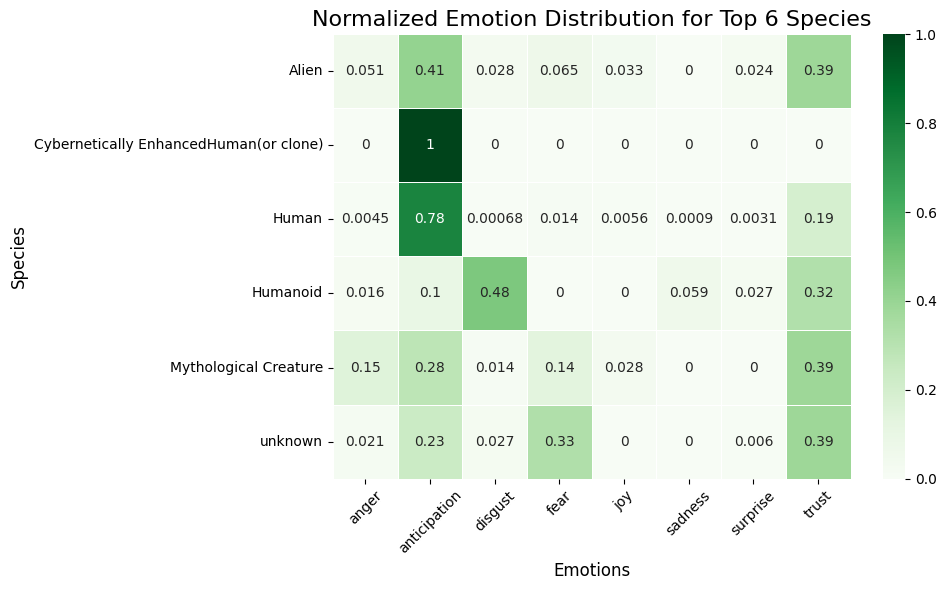

In [ ]:
top_species = all_emotion_df['Species'].value_counts().head(6).index
filtered_df = species_emotion_counts[species_emotion_counts['Species'].isin(top_species)]

species_emotion_pivot = filtered_df.pivot(index='Species', columns='Predominant Emotion', values='Count').fillna(0)
species_emotion_pivot_normalized = species_emotion_pivot.div(species_emotion_pivot.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(
    species_emotion_pivot_normalized, 
    annot=True, 
    cmap="Greens", 
    cbar=True, 
    linewidths=0.5
)
plt.title("Normalized Emotion Distribution for Top 6 Species", fontsize=16)
plt.xlabel("Emotions", fontsize=12)
plt.ylabel("Species", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Alien: 

- Key Emotions: Anticipation (41.3%), Trust, (38.6%). Aliens are heavily featured with emotions related to planning and collaboration befitting their role in furthering or hindering the protagonist's goals in a narrative.

Cybernetically Enhanced Humans (or Clones):

- Key Emotion: Anticipation 100%. This species is completely associated with the future or strategy, posed from their origins: either technology or experiment.

Human:

- Key Emotions: Anticipation (77.8%), Trust (19.3%). The narration is dominated by humans and shows emotions related to preparation and dependability. Their second important trust score reflects interpersonal relationships and bonds inside the 
Smith family.

Humanoid:

- Key Emotions: Disgust (47.6%), Trust (32.1%). Humanoids express mixed feelings: both negative and positive; it can be related to morally ambiguous or alien-like roles within the story.

Mythical Animal:

- Key Emotions: Trust (38.7%), Anticipation (28.3%), and Fear (13.6%). Mythological creatures vary in their use-from ally to source of tension. In many cases, anticipation also ties into their often mystical or mysterious context within a storyline.

Unknown: 

- Key Emotions: Trust 38.6%), Fear (32.6%). Unseen-species characters are examples of things that are usually unstable or mysterious. Thus, cooperation and fear-driven roles of this character balance in this storyline.

# Part 5: Conclusion

This concludes the analysis of the *Rick and Morty* universe. The project explored the show as a network, highlighting how its characters and episodes form an intricate web of connections. By examining the network structure, we identified distinct communities shaped by species and character types, offering insights into how the narrative divides into various groups. 

The analysis of the top 10 most popular characters aligned closely with expectations, featuring central figures like Rick and Morty themselves. By integrating character data with episode transcripts, a detailed sentiment analysis was conducted, shedding light on the overall use of words, their emotional tone, and the sentiments expressed by the most vocal characters. 

The findings reveal a nuanced linguistic landscape within *Rick and Morty*, showcasing a mix of emotions that create a largely neutral tone with bursts of strong sentiment. The analysis of the top 5 words within each sentiment category reflects the show’s unfiltered style, with expectedly bold and edgy language such as "shit" and "bitch" appearing prominently. 

Overall, the project offers a comprehensive view of *Rick and Morty*, from its interconnected character dynamics to the colorful and expressive language that defines its unique storytelling.